R250: Unsupervised Learning with Gaussian Processes
===================================================

### [Neil D. Lawrence](http://inverseprobability.com), University of

Cambridge

### 2021-01-21

**Abstract**: In this talk we give an introduction to Unsupervised
Learning and Gaussian processes for students who are interested in
working with Unsupervised GPs for the the R250 module.

$$
$$

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

Setup
-----

First we download some libraries and files to support the notebook.

In [ ]:
import urllib.request

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')

In [ ]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<!--setupplotcode{import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set_palette('colorblind')}-->

pods
----

In Sheffield we created a suite of software tools for ‘Open Data
Science’. Open data science is an approach to sharing code, models and
data that should make it easier for companies, health professionals and
scientists to gain access to data science techniques.

You can also check this blog post on [Open Data
Science](http://inverseprobability.com/2014/07/01/open-data-science).

The software can be installed using

In [ ]:
%pip install --upgrade git+https://github.com/sods/ods

from the command prompt where you can access your python installation.

The code is also available on github:
<a href="https://github.com/sods/ods" class="uri">https://github.com/sods/ods</a>

Once `pods` is installed, it can be imported in the usual manner.

In [ ]:
import pods

High Dimensional Data
---------------------

To introduce high dimensional data, we will first of all introduce a
hand written digit from the U.S. Postal Service handwritten digit data
set (originally collected from scanning enveolopes) and used in the
first convolutional neural network paper (Le Cun et al., 1989).

Le Cun et al. (1989) downscaled the images to $16 \times 16$, here we
use an image at the original scale, containing 64 rows and 57 columns.
Since the pixels are binary, and the number of dimensions is 3,648, this
space contains $2^{3,648}$ possible images. So this space contains a lot
more than just one digit.

USPS Samples
------------

If we sample from this space, taking each pixel independently from a
probability which is given by the number of pixels which are ‘on’ in the
original image, over the total number of pixels, we see images that look
nothing like the original digit.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

six_image = mlai.load_pgm('br1561_6.3.pgm', directory ='../slides/diagrams/ml')
rows = six_image.shape[0]
col = six_image.shape[1]
      
ax.imshow(six_image,interpolation='none').set_cmap('gray')
mlai.write_figure('./dimred/dem_six000.png')
for i in range(3):
    rand_image = np.random.rand(rows, col)<((six_image>0).sum()/float(rows*col))
    ax.imshow(rand_image,interpolation='none').set_cmap('gray')
    mlai.write_figure('./dimred/dem_six{i:0>3}.png'.format(i=i+1))

In [ ]:
from ipywidgets import IntSlider
import pods

In [ ]:
pods.notebook.display_plots('dem_six{counter:0>3}.png', directory='./ml', counter=IntSlider(0, 0, 3, 1))

<table>
<tr>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six000.png" style="width:100%">

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six001.png" style="width:100%">

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six002.png" style="width:100%">

</td>
</tr>
</table>

Figure: <i>Even if we sample every nano second from now until the end of
the universe we won’t see the original six again.</i>

Even if we sample every nanosecond from now until the end of the
universe you won’t see the original six again.

Simple Model of Digit
---------------------

So, an independent pixel model for this digit doesn’t seem sensible. The
total space is enormous, and yet the space occupied by the type of data
we’re interested in is relatively small.

Consider a different type of model. One where we take a prototype six
and we rotate it left and right to create new data.

In [ ]:
from scipy.misc import imrotate

In [ ]:
six_image = mlai.load_pgm('br1561_6.3.pgm', directory ='../slides/diagrams/dimred')
six_image = np.hstack([np.zeros((rows, 3)), six_image, np.zeros((rows, 4))])
dim_one = np.asarray(six_image.shape)
angles = range(360)
i = 0
Y = np.zeros((len(angles), np.prod(dim_one)))
for angle in angles:
    rot_image = rotate(six_image, angle, mode='nearest')
    dim_two = np.asarray(rot_image.shape)
    start = [int(round((dim_two[0] - dim_one[0])/2)), int(round((dim_two[1] - dim_one[1])/2))]
    crop_image = rot_image[start[0]+np.array(range(dim_one[0])), :][:, start[1]+np.array(range(dim_one[1]))]
    Y[i, :] = crop_image.flatten()

In [ ]:
pods.notebook.display_plots('../slides/diagrams/dimred/dem_six_rotate{counter:0>3}.png', directory='./ml', counter=(0, 6))

<table>
<tr>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six_rotate001.png" style="width:100%">

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six_rotate003.png" style="width:100%">

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_six_rotate005.png" style="width:100%">

</td>
</tr>
</table>

Figure: <i>Rotate a prototype six to form a set of plausible sixes.</i>

<table>
<tr>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_manifold_print001.png" style="width:100%">

</td>
<td width="30%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/dem_manifold_print002.png" style="width:100%">

</td>
</tr>
</table>

Figure: <i>The rotated sixes projected onto the first two principal
components of the ‘rotated data set’. The data lives on a one
dimensional manifold in the 3,648 dimensional space.</i>

Low Dimensional Manifolds
-------------------------

Of course, in practice pure rotation of the image is too simple a model.
Digits can undergo several distortions and retain their nature. For
example, they can be scaled, they can go through translation, they can
udnergo ‘thinning’. But, for data with ‘structure’ we expect fewer of
these distortions than the dimension of the data. This means we expect
data to live on a lower dimensonal manifold. This implies that we should
deal with high dimensional data by looking for a lower dimensional
(non-linear) embedding.

Dimensionality Reduction
------------------------

Dimensionality reduction methods compress the data by replacing the
original data with a reduced number of continuous variables. One way of
thinking of these methods is to imagine a marionette.

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/ml/marionette.svg" class="" width="40%" style="vertical-align:middle;">

Figure: <i>Thinking of dimensionality reduction as a marionette. We
observe the high dimensional pose of the puppet, $\mathbf{ x}$, but the
movement of the puppeteer’s hand, $\mathbf{ z}$ remains hidden to us.
Dimensionality reduction aims to recover those hidden movements which
generated the observations.</i>

The position of each body part of a marionette could be thought of as
our data, $\mathbf{ x}_i$. So, each data point consists of the 3-D
co-ordinates of all the different body parts of the marionette. Let’s
say there are 13 different body parts (2 each of feet, knees, hips,
hands, elbows, shoulders, one head). Each body part has an x, y, z
position in Cartesian coordinates. So that’s 39 numbers associated with
each observation.

The movement of these 39 parts is determined by the puppeteer via
strings. Let’s assume it’s a very simple puppet, with just one stick to
control it. The puppeteer can move the stick up and down, left and
right. And they can twist it. This gives three parameters in the
puppeteers control. This implies that the 39 variables we see moving are
controlled by only 3 variables. These 3 variables are often called the
hidden or *latent variables*.

Dimensionality reduction assumes something similar for real world data.
It assumes that the data we observe is generated from some lower
dimensional underlying process. It then seeks to recover the values
associated with this low dimensional process.

### Examples in Social Sciences

Dimensionality reduction techniques underpin a lot of psychological
scoring tests such as IQ tests or personality tests. An IQ test can
involve several hundred questions, potentially giving a rich, high
dimensional, characterization of some aspects of your intelligence. It
is then summarized by a single number. Similarly, the Myers-Briggs
personality test involves answering questions about preferences which
are reduced to a set of numbers reflecting personality.

These tests are assuming that our intelligence is implicitly
one-dimensional and that our personality is implicitly four dimensional.
Other examples include political belief which is typically represented
on a left to right scale. A one-dimensional distillation of an entire
philosophy about how a country should be run. Our own leadership
principles imply that our decisions have a fourteen-dimensional space
underlying them. Each decision could be characterized by judging to what
extent it embodies each of the principles.

Political belief, personality, intelligence, leadership. None of these
exist as a directly measurable quantity in the real world, rather they
are inferred based on measurables. Dimensionality reduction is the
process of allowing the computer to automatically find such underlying
dimensions. This automatically allowing us to characterize each data
point according to those explanatory variables. Each of these
characteristics can be scored, and individuals can then be turned into
vectors.

This doesn’t only apply to individuals, in recent years work on language
modeling has taken a similar approach to words. The
[word2vec](https://arxiv.org/abs/1301.3781) algorithm performed a
dimensionality reduction on words, now you can take any word and map it
to a latent space where similar words exhibit similar characteristics. A
‘personality space’ for words.

Gaussian Variables and Linear Dimensionality Reduction
------------------------------------------------------

We will return to non-linear dimensionality reduction approaches
shortly, but first we’re going to consider *linear* approaches to
dimensionality reduction. To do so, we’ll first review some
characteristics of the Gaussian density.

Two Important Gaussian Properties
---------------------------------

The Gaussian density has many important properties, but for the moment
we’ll review two of them.

Sum of Gaussians
----------------

If we assume that a variable, $y_i$, is sampled from a Gaussian density,

$$y_i \sim \mathcal{N}\left(\mu_i,\sigma_i^2\right)$$

Then we can show that the sum of a set of variables, each drawn
independently from such a density is also distributed as Gaussian. The
mean of the resulting density is the sum of the means, and the variance
is the sum of the variances,

$$
\sum_{i=1}^{n} y_i \sim \mathcal{N}\left(\sum_{i=1}^n\mu_i,\sum_{i=1}^n\sigma_i^2\right)
$$

Since we are very familiar with the Gaussian density and its properties,
it is not immediately apparent how unusual this is. Most random
variables, when you add them together, change the family of density they
are drawn from. For example, the Gaussian is exceptional in this regard.
Indeed, other random variables, if they are independently drawn and
summed together tend to a Gaussian density. That is the [*central limit
theorem*](https://en.wikipedia.org/wiki/Central_limit_theorem) which is
a major justification for the use of a Gaussian density.

Scaling a Gaussian
------------------

Less unusual is the *scaling* property of a Gaussian density. If a
variable, $y$, is sampled from a Gaussian density,

$$y\sim \mathcal{N}\left(\mu,\sigma^2\right)$$ and we choose to scale
that variable by a *deterministic* value, $w$, then the *scaled
variable* is distributed as

$$wy\sim \mathcal{N}\left(w\mu,w^2 \sigma^2\right).$$ Unlike the summing
properties, where adding two or more random variables independently
sampled from a family of densitites typically brings the summed variable
*outside* that family, scaling many densities leaves the distribution of
that variable in the same *family* of densities. Indeed, many densities
include a *scale* parameter (e.g. the [Gamma
density](https://en.wikipedia.org/wiki/Gamma_distribution)) which is
purely for this purpose. In the Gaussian the standard deviation,
$\sigma$, is the scale parameter. To see why this makes sense, let’s
consider, $$z \sim \mathcal{N}\left(0,1\right),$$ then if we scale by
$\sigma$ so we have, $y=\sigma z$, we can write,
$$y=\sigma z \sim \mathcal{N}\left(0,\sigma^2\right)$$

Let’s first of all review the properties of the multivariate Gaussian
distribution that make linear Gaussian models easier to deal with. We’ll
return to the, perhaps surprising, result on the parameters within the
nonlinearity, $\boldsymbol{ \theta}$, shortly.

To work with linear Gaussian models, to find the marginal likelihood all
you need to know is the following rules. If $$
\mathbf{ y}= \mathbf{W}\mathbf{ x}+ \boldsymbol{ \epsilon},
$$ where $\mathbf{ y}$, $\mathbf{ x}$ and $\boldsymbol{ \epsilon}$ are
vectors and we assume that $\mathbf{ x}$ and $\boldsymbol{ \epsilon}$
are drawn from multivariate Gaussians, $$
\begin{align}
\mathbf{ x}& \sim \mathcal{N}\left(\boldsymbol{ \mu},\mathbf{C}\right)\\
\boldsymbol{ \epsilon}& \sim \mathcal{N}\left(\mathbf{0},\boldsymbol{ \Sigma}\right)
\end{align}
$$ then we know that $\mathbf{ y}$ is also drawn from a multivariate
Gaussian with, $$
\mathbf{ y}\sim \mathcal{N}\left(\mathbf{W}\boldsymbol{ \mu},\mathbf{W}\mathbf{C}\mathbf{W}^\top + \boldsymbol{ \Sigma}\right).
$$

With appropriately defined covariance, $\boldsymbol{ \Sigma}$, this is
actually the marginal likelihood for Factor Analysis, or Probabilistic
Principal Component Analysis (Tipping and Bishop, 1999a), because we
integrated out the inputs (or *latent* variables they would be called in
that case).

Latent Variables
================

Latent means hidden, and hidden variables are simply *unobservable*
variables. The idea of a latent variable is crucial to the concept of
artificial intelligence, machine learning and experimental design. A
latent variable could take many forms. We might observe a man walking
along a road with a large bag of clothes and we might *infer* that the
man is walking to the laundrette. Our observations are a highly complex
data space, the response in our eyes is processed through our visual
cortex, the combination of the individual’s limb movememnts and the
direction they are walking in all conflate in our heads to cause us to
infer that (perhaps) the individual is going to the laundrette. We don’t
*know* that the man is walking to the laundrette, but we have a model of
the world that suggests that it’s a likely outcome for the very complex
data. In some ways the latent variable can be seen as a *compression* of
this very complex scene. If I were writing a book, I might write that “A
man tripped over whilst walking to the laundrette”. In the reader’s mind
an image of a man, perhaps laden with dirty clothes, may occur. All
these ideas come from our expectations of the world around us. We can
make further inference about the man, some of it perhaps plausible
others less so. The man may be going to the laundrette because his
washing machine is broken, or because he doesn’t have a large enough
flat to have a washing machine, or because he’s carrying a duvet, or
because he doesn’t like ironing. All of these may *increase* in
probability given our observation, but they are still *latent*
variables. Unless we follow the man back to his appartment, or start
making other enquirires about the man, we don’t know the true answer.

It’s clear that to do inference about any complex system we *must*
include latent variables. Latent variables are extremely powerful. In
robotics, they are used to represent the *state* of the robot. The state
of the robot may include its position (in x, y coordinates) its speed,
its direction of facing. How are *these* variables unknown to the robot?
Well the robot only posesses *sensors*, it can make observations of the
nearest object in a certain direction, and it may have a map of its
environment. If we represent the state of the robot as its position on a
map, it may be uncertain of that position. If you go walking or running
in the hills around Sheffield, you can take a very high quality ordnance
survey map with you. However, unless you are a really excellent
orienteer, when you are far from any given landmark, you will probably
be *uncertain* about your true position on the map. These states are
also latent variables.

In statistical analysis of experiments you try to control for each
aspect of the experiment, in particular by *randomization*. So if I’m
interested in the ability of a particular fertilizer to improve the
yield of a particular plant I may design an experiment where I apply the
fertilizer to some plants (the treatment group) and withold the
fertilizer from others (the control group). I then test to see whether
the yield from the treatment group is better (or worse) than the control
group. I may find that I have an excellent yield for the treatment
group. However, what if I’d (unknowlingly) planted all my treatment
plants in a sunny part of the field, and all the control plants in a
shady part of the field. That would also be a latent variable, in this
case known as a *confounder*. In statistical experimental design
*randomization* is used to attempt to eliminate the correlated effects
of these confounders: you aim to ensure that if these confounders *do*
exist their effects are not correlated with treatment and contorl. This
is known as a [randomized control
trial](http://en.wikipedia.org/wiki/Randomized_controlled_trial).

Greek philosophers worried a great deal about what was knowable and what
was unknowable. Adherents of [philosophical
Skeptisism](http://en.wikipedia.org/wiki/Skepticism) were inspired by
the idea that since your senses sometimes give you contradictory
information, they cannot be trusted, and in extreme cases they chose to
*ignore* their senses. This is an acknowledgement that very often the
true state of the world cannot be known with precision. Unfortunately,
these philosophers didn’t have a good understanding of probability, so
they were unable to encapsulate their ideas through a *degree* of
belief.

We often use language to express the compression of a complex behavior
or patterns in a simpler way, for example we talk about motives as a
useful distallation for a perhaps very complex patter of behavior. In
physics we use principles of causation and simple laws to describe the
world around us. Such motives or underlying principles are difficult to
observe directly, our conclusions about them emerge over a period of
time by observing indirect consequences of the latent variables.

Epistemic uncertainty allows us to deal with these worries by
associating our degree of belief about the state of the world with a
probaiblity distribution. This core idea underpins state space
modelling, probabilistic graphical models and the wider field of latent
variable modelling. In this session we are going to explore the idea in
a simple linear system and see how it relates to *factor analysis* and
*principal component analysis*.

Your Personality
================

At the beginning of the 20th century there was a great deal of interest
amoungst psychologists in formalizing patterns of thought. The approach
they used became known as factor analysis. The principle is that we
observe a potentially high dimensional vector of characteristics about
an individual. To formalize this, social scientists designed
questionaires. We can envisage many questions that we may ask, but the
assumption is that underlying these questions there are only a few
traits that dictate the behavior. These models are known as latent trait
models and the analysis is sometimes known as factor analysis. The idea
is that there are a few characteristic traits that we are looking to
discern. These traits or factors can be extracted by assimilating the
high dimensional characteristics of the individual into a few latent
factors.

::: {.cell .markdown}

Factor Analysis Model
---------------------

This causes us to consider a model as follows, if we are given a high
dimensional vector of features (perhaps questionaire answers) associated
with an individual, $\mathbf{ y}$, we assume that these factors are
actually generated from a low dimensional vector latent traits, or
latent variables, which determine the personality. $$
\mathbf{ y}= \mathbf{f}(\mathbf{ z}) + \boldsymbol{ \epsilon},
$$ where $\mathbf{f}(\mathbf{ z})$ is a *vector valued* function that is
dependent on the latent traits and $\boldsymbol{ \epsilon}$ is some
corrupting noise. For simplicity, we assume that the function is given
by a *linear* relationship, $$
\mathbf{f}(\mathbf{ z}) = \mathbf{W}\mathbf{ z}
$$ where we have introduced a matrix $\mathbf{W}$ that is sometimes
referred to as the *factor loadings* but we also immediately see is
related to our *multivariate linear regression* models from the . That
is because our vector valued function is of the form

$$
\mathbf{f}(\mathbf{ z}) =
\begin{bmatrix} f_1(\mathbf{ z}) \\ f_2(\mathbf{ z}) \\ \vdots \\
f_p(\mathbf{ z})\end{bmatrix}
$$ where there are $p$ features associated with the individual. If we
consider any of these functions individually we have a prediction
function that looks like a regression model, $$
f_j(\mathbf{ z}) =
\mathbf{ w}_{j, :}^\top \mathbf{ z},
$$ for each element of the vector valued function, where
$\mathbf{ w}_{:, j}$ is the $j$th column of the matrix $\mathbf{W}$. In
that context each column of $\mathbf{W}$ is a vector of *regression
weights*. This is a multiple input and multiple output regression. Our
inputs (or covariates) have dimensionality greater than 1 and our
outputs (or response variables) also have dimensionality greater than
one. Just as in a standard regression, we are assuming that we don’t
observe the function directly (note that this *also* makes the function
a *type* of latent variable), but we observe some corrupted variant of
the function, where the corruption is given by $\boldsymbol{ \epsilon}$.
Just as in linear regression we can assume that this corruption is given
by Gaussian noise, where the noise for the $j$th element of
$\mathbf{ y}$ is by, $$
\epsilon_j \sim \mathcal{N}\left(0,\sigma^2_j\right).
$$ Of course, just as in a regression problem we also need to make an
assumption across the individual data points to form our full
likelihood. Our data set now consists of many observations of
$\mathbf{ y}$ for diffetent individuals. We store these observations in
a *design matrix*, $\mathbf{Y}$, where each *row* of $\mathbf{Y}$
contains the observation for one individual. To emphasize that
$\mathbf{ y}$ is a vector derived from a row of $\mathbf{Y}$ we
represent the observation of the features associated with the $i$th
individual by $\mathbf{ y}_{i, :}$, and place each individual in our
data matrix,

$$
\mathbf{Y}
= \begin{bmatrix} \mathbf{ y}_{1, :}^\top \\ \mathbf{ y}_{2, :}^\top \\ \vdots \\
\mathbf{ y}_{n, :}^\top\end{bmatrix},
$$ where we have $n$ data points. Our data matrix therefore has $n$ rows
and $p$ columns. The point to notice here is that each data obsesrvation
appears as a row vector in the design matrix (thus the transpose
operation inside the brackets). Our prediction functions are now
actually a *matrix value* function, $$
\mathbf{F} = \mathbf{Z}\mathbf{W}^\top,
$$ where for each matrix the data points are in the rows and the data
features are in the columns. This implies that if we have $q$ inputs to
the function we have $\mathbf{F}\in \Re^{n\times p}$,
$\mathbf{W}\in \Re^{p \times q}$ and $\mathbf{Z}\in \Re^{n\times q}$.

### Exercise 1

Show that, given all the definitions above, if, $$
\mathbf{F} = \mathbf{Z}\mathbf{W}^\top
$$ and the elements of the vector valued function $\mathbf{F}$ are given
by $$
f_{i, j} = f_j(\mathbf{ z}_{i, :}),
$$ where $\mathbf{ z}_{i, :}$ is the $i$th row of the latent variables,
$\mathbf{Z}$, then show that $$
f_j(\mathbf{ z}_{i, :}) = \mathbf{ w}_{j, :}^\top
\mathbf{ z}_{i, :}
$$

### Exercise 1 Answer

Write your answer to Exercise 1 here

Latent Variables vs Linear Regression
-------------------------------------

The difference between this model and a multiple output regression is
that in the regression case we are provided with the covariates
$\mathbf{Z}$, here they are *latent variables*. These variables are
unknown. Just as we have done in the past for unknowns, we now treat
them with a probability distribution. In *factor analysis* we assume
that the latent variables have a Gaussian density which is independent
across both across the latent variables associated with the different
data points, and across those associated with different data features,
so we have, $$
x_{i,j} \sim
\mathcal{N}\left(0,1\right),
$$ and we can write the density governing the latent variable associated
with a single point as, $$
\mathbf{ z}_{i, :} \sim \mathcal{N}\left(\mathbf{0},\mathbf{I}\right).
$$ If we consider the values of the function for the $i$th data point as
$$
\mathbf{f}_{i, :} =
\mathbf{f}(\mathbf{ z}_{i, :}) = \mathbf{W}\mathbf{ z}_{i, :} 
$$ then we can use the rules for multivariate Gaussian relationships to
write that $$
\mathbf{f}_{i, :} \sim \mathcal{N}\left(\mathbf{0},\mathbf{W}\mathbf{W}^\top\right)
$$ which implies that the distribution for $\mathbf{ y}_{i, :}$ is given
by $$
\mathbf{ y}_{i, :} = \sim \mathcal{N}\left(\mathbf{0},\mathbf{W}\mathbf{W}^\top + \boldsymbol{\Sigma}\right)
$$ where $\boldsymbol{\Sigma}$ the covariance of the noise variable,
$\epsilon_{i, :}$ which for factor analysis is a diagonal matrix
(because we have assumed that the noise was *independent* across the
features), $$
\boldsymbol{\Sigma} = \begin{bmatrix}\sigma^2_{1} & 0 & 0 & 0\\
0 & \sigma^2_{2} & 0 & 0\\
                                     0 & 0 & \ddots &
0\\
                                     0 & 0 & 0 & \sigma^2_p\end{bmatrix}.
$$ For completeness, we could also add in a *mean* for the data vector
$\boldsymbol{ \mu}$, $$
\mathbf{ y}_{i, :} = \mathbf{W}\mathbf{ z}_{i, :} +
\boldsymbol{ \mu}+ \boldsymbol{ \epsilon}_{i, :}
$$ which would give our marginal distribution for $\mathbf{ y}_{i, :}$ a
mean $\boldsymbol{ \mu}$. However, the maximum likelihood solution for
$\boldsymbol{ \mu}$ turns out to equal the empirical mean of the data,
$$
\boldsymbol{ \mu}= \frac{1}{n} \sum_{i=1}^n
\mathbf{ y}_{i, :},
$$ *regardless* of the form of the covariance,
$\mathbf{C}= \mathbf{W}\mathbf{W}^\top + \boldsymbol{\Sigma}$. As a
result it is very common to simply preprocess the data and ensure it is
zero mean. We will follow that convention for this session.

The prior density over latent variables is independent, and the
likelihood is independent, that means that the marginal likelihood here
is also independent over the data points. Factor analysis was developed
mainly in psychology and the social sciences for understanding
personality and intelligence. [Charles
Spearman](http://en.wikipedia.org/wiki/Charles_Spearman) was concerned
with the measurements of “the abilities of man” and is credited with the
earliest version of factor analysis.

Principal Component Analysis
============================

In 1933 [Harold
Hotelling](http://en.wikipedia.org/wiki/Harold_Hotelling) published on
*principal component analysis* the first mention of this approach
(Hotelling, 1933). Hotelling’s inspiration was to provide mathematical
foundation for factor analysis methods that were by then widely used
within psychology and the social sciences. His model was a factor
analysis model, but he considered the noiseless ‘limit’ of the model. In
other words he took $\sigma^2_i \rightarrow 0$ so that he had

$$
\mathbf{ y}_{i, :} \sim \lim_{\sigma^2 \rightarrow 0} \mathcal{N}\left(\mathbf{0},\mathbf{W}\mathbf{W}^\top + \sigma^2 \mathbf{I}\right).
$$ The paper had two unfortunate effects. Firstly, the resulting model
is no longer valid probablistically, because the covariance of this
Gaussian is ‘degenerate’. Because $\mathbf{W}\mathbf{W}^\top$ has rank
of at most $q$ where $q<p$ (due to the dimensionality reduction) the
determinant of the covariance is zero, meaning the inverse doesn’t exist
so the density, $$
p(\mathbf{ y}_{i, :}|\mathbf{W}) =
\lim_{\sigma^2 \rightarrow 0} \frac{1}{(2\pi)^\frac{p}{2}
|\mathbf{W}\mathbf{W}^\top + \sigma^2 \mathbf{I}|^{\frac{1}{2}}}
\exp\left(-\frac{1}{2}\mathbf{ y}_{i, :}\left[\mathbf{W}\mathbf{W}^\top+ \sigma^2
\mathbf{I}\right]^{-1}\mathbf{ y}_{i, :}\right),
$$ is *not* valid for $q<p$ (where $\mathbf{W}\in \Re^{p\times q}$).
This mathematical consequence is a probability density which has no
‘support’ in large regions of the space for $\mathbf{ y}_{i, :}$. There
are regions for which the probability of $\mathbf{ y}_{i, :}$ is zero.
These are any regions that lie off the hyperplane defined by mapping
from $\mathbf{ z}$ to $\mathbf{ y}$ with the matrix $\mathbf{W}$. In
factor analysis the noise corruption, $\boldsymbol{ \epsilon}$, allows
for points to be found away from the hyperplane. In Hotelling’s PCA the
noise variance is zero, so there is only support for points that fall
precisely on the hyperplane. Secondly, Hotelling explicity chose to
rename factor analysis as principal component analysis, arguing that the
factors social scientist sought were different in nature to the concept
of a mathematical factor. This was unfortunate because the factor
loadings, $\mathbf{W}$ can also be seen as factors in the mathematical
sense because the model Hotelling defined is a Gaussian model with
covariance given by $\mathbf{C}= \mathbf{W}\mathbf{W}^\top$ so
$\mathbf{W}$ is a *factor* of the covariance in the mathematical sense,
as well as a factor loading.

However, the paper had one great advantage over standard approaches to
factor analysis. Despite the fact that the model was a special case that
is subsumed by the more general approach of factor analysis it is this
special case that leads to a particular algorithm, namely that the
factor loadings (or principal components as Hotelling referred to them)
are given by an *eigenvalue decomposition* of the empirical covariance
matrix.

Computation of the Marginal Likelihood
--------------------------------------

$$
\mathbf{ y}_{i,:}=\mathbf{W}\mathbf{ z}_{i,:}+\boldsymbol{ \epsilon}_{i,:},\quad \mathbf{ z}_{i,:} \sim \mathcal{N}\left(\mathbf{0},\mathbf{I}\right), \quad \boldsymbol{ \epsilon}_{i,:} \sim \mathcal{N}\left(\mathbf{0},\sigma^{2}\mathbf{I}\right)
$$

$$
\mathbf{W}\mathbf{ z}_{i,:} \sim \mathcal{N}\left(\mathbf{0},\mathbf{W}\mathbf{W}^\top\right)
$$

$$
\mathbf{W}\mathbf{ z}_{i, :} + \boldsymbol{ \epsilon}_{i, :} \sim \mathcal{N}\left(\mathbf{0},\mathbf{W}\mathbf{W}^\top + \sigma^2 \mathbf{I}\right)
$$

**Probabilistic PCA Max. Likelihood Soln** (Tipping and Bishop (1999a))

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/ppca_graph.png" style="width:40%">

Figure: <i>Graphical model representing probabilistic PCA.</i>

$$p\left(\mathbf{Y}|\mathbf{W}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ y}_{i, :}|\mathbf{0},\mathbf{W}\mathbf{W}^{\top}+\sigma^{2}\mathbf{I}\right)$$

Eigenvalue Decomposition
------------------------

Eigenvalue problems are widespreads in physics and mathematics, they are
often written as a matrix/vector equation but we prefer to write them as
a full matrix equation. In an eigenvalue problem you are looking to find
a matrix of eigenvectors, $\mathbf{U}$ and a *diagonal* matrix of
eigenvalues, $\boldsymbol{\Lambda}$ that satisfy the *matrix* equation
$$
\mathbf{A}\mathbf{U} = \mathbf{U}\boldsymbol{\Lambda}.
$$ where $\mathbf{A}$ is your matrix of interest. This equation is not
trivially solvable through matrix inverse because matrix multiplication
is not [commutative](http://en.wikipedia.org/wiki/Commutative_property),
so premultiplying by $\mathbf{U}^{-1}$ gives $$
\mathbf{U}^{-1}\mathbf{A}\mathbf{U}
= \boldsymbol{\Lambda}, 
$$ where we remember that $\boldsymbol{\Lambda}$ is a *diagonal* matrix,
so the eigenvectors can be used to *diagonalise* the matrix. When
performing the eigendecomposition on a Gaussian covariances,
diagonalisation is very important because it returns the covariance to a
form where there is no correlation between points.

::: {.cell .markdown}

Positive Definite
-----------------

We are interested in the case where $\mathbf{A}$ is a covariance matrix,
which implies it is *positive definite*. A positive definite matrix is
one for which the inner product, $$
\mathbf{ w}^\top \mathbf{C}\mathbf{ w}
$$ is positive for *all* values of the vector $\mathbf{ w}$ other than
the zero vector. One way of creating a positive definite matrix is to
assume that the symmetric and positive definite matrix
$\mathbf{C}\in \Re^{p\times p}$ is factorised into,
$\mathbf{A}in \Re^{p\times p}$, a *full rank* matrix, so that $$
\mathbf{C}= \mathbf{A}^\top
\mathbf{A}.
$$ This ensures that $\mathbf{C}$ must be positive definite because $$
\mathbf{ w}^\top \mathbf{C}\mathbf{ w}=\mathbf{ w}^\top
\mathbf{A}^\top\mathbf{A}\mathbf{ w}
$$ and if we now define a new *vector* $\mathbf{b}$ as $$
\mathbf{b} = \mathbf{A}\mathbf{ w}
$$ we can now rewrite as $$
\mathbf{ w}^\top \mathbf{C}\mathbf{ w}= \mathbf{b}^\top\mathbf{b} = \sum_{i}
b_i^2
$$ which, since it is a sum of squares, is positive or zero. The
constraint that $\mathbf{A}$ must be *full rank* ensures that there is
no vector $\mathbf{ w}$, other than the zero vector, which causes the
vector $\mathbf{b}$ to be all zeros.

### Exercise 1

If $\mathbf{C}=\mathbf{A}^\top \mathbf{A}$ then express $c_{i,j}$, the
value of the element at the $i$th row and the $j$th column of
$\mathbf{C}$, in terms of the columns of $\mathbf{A}$. Use this to show
that (i) the matrix is symmetric and (ii) the matrix has positive
elements along its diagonal.

### Exercise 1 Answer

Write your answer to Exercise 1 here

Eigenvectors of a Symmetric Matric
----------------------------------

Symmetric matrices have *orthonormal* eigenvectors. This means that
$\mathbf{U}$ is an [orthogonal
matrix](http://en.wikipedia.org/wiki/Orthogonal_matrix),
$\mathbf{U}^\top\mathbf{U} = \mathbf{I}$. This implies that
$\mathbf{u}_{:, i} ^\top \mathbf{u}_{:, j}$ is equal to 0 if $i\neq j$
and 1 if $i=j$.

Principal Component Analysis
----------------------------

-   PCA (Hotelling (1933)) is a linear embedding.

-   Today its presented as:

    -   Rotate to find ‘directions’ in data with maximal variance.
    -   How do we find these directions?

-   Algorithmically we do this by diagonalizing the sample covariance
    matrix $$
    \mathbf{S}=\frac{1}{n}\sum_{i=1}^n\left(\mathbf{ y}_{i, :}-\boldsymbol{ \mu}\right)\left(\mathbf{ y}_{i, :} - \boldsymbol{ \mu}\right)^\top
    $$

-   Find directions in the data, $\mathbf{ z}= \mathbf{U}\mathbf{ y}$,
    for which variance is maximized.

-   Solution is found via constrained optimisation (which uses [Lagrange
    multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier)): $$
    L\left(\mathbf{u}_{1},\lambda_{1}\right)=\mathbf{u}_{1}^{\top}\mathbf{S}\mathbf{u}_{1}+\lambda_{1}\left(1-\mathbf{u}_{1}^{\top}\mathbf{u}_{1}\right)
    $$

-   Gradient with respect to $\mathbf{u}_{1}$
    $$\frac{\text{d}L\left(\mathbf{u}_{1},\lambda_{1}\right)}{\text{d}\mathbf{u}_{1}}=2\mathbf{S}\mathbf{u}_{1}-2\lambda_{1}\mathbf{u}_{1}$$
    rearrange to form
    $$\mathbf{S}\mathbf{u}_{1}=\lambda_{1}\mathbf{u}_{1}.$$ Which is
    known as an [*eigenvalue
    problem*](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors).

-   Further directions that are *orthogonal* to the first can also be
    shown to be eigenvectors of the covariance.

-   Represent data, $\mathbf{Y}$, with a lower dimensional set of latent
    variables $\mathbf{Z}$.

-   Assume a linear relationship of the form $$
    \mathbf{ y}_{i,:}=\mathbf{W}\mathbf{ z}_{i,:}+\boldsymbol{ \epsilon}_{i,:},
    $$ where $$
    \boldsymbol{ \epsilon}_{i,:} \sim \mathcal{N}\left(\mathbf{0},\sigma^2\mathbf{I}\right)
    $$

**Probabilistic PCA**

<table>
<tr>
<td width>

-   Define *linear-Gaussian relationship* between latent variables and
    data.
-   **Standard** Latent variable approach:
    -   Define Gaussian prior over *latent space*, $\mathbf{Z}$.
-   Integrate out *latent variables*. `{=html}     </td>`
    `{=html}     <td width="">`

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/ppca_graph.png" style="width:40%">

Figure: <i>Graphical model representing probabilistic PCA.</i>

$$
p\left(\mathbf{Y}|\mathbf{Z},\mathbf{W}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ y}_{i,:}|\mathbf{W}\mathbf{ z}_{i,:},\sigma^2\mathbf{I}\right)
$$

$$
p\left(\mathbf{Z}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ z}_{i,:}|\mathbf{0},\mathbf{I}\right)
$$

$$
p\left(\mathbf{Y}|\mathbf{W}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ y}_{i,:}|\mathbf{0},\mathbf{W}\mathbf{W}^{\top}+\sigma^{2}\mathbf{I}\right)
$$

</td>
</tr>
</table>

Probabilistic PCA
=================

In 1997 [Tipping and
Bishop](http://research.microsoft.com/pubs/67218/bishop-ppca-jrss.pdf)
(Tipping and Bishop, 1999b) and
[Roweis](https://www.cs.nyu.edu/~roweis/papers/empca.pdf) (Roweis, n.d.)
independently revisited Hotelling’s model and considered the case where
the noise variance was finite, but *shared* across all output dimensons.
Their model can be thought of as a factor analysis where $$
\boldsymbol{\Sigma} = \sigma^2 \mathbf{I}.
$$ This leads to a marginal likelihood of the form $$
p(\mathbf{Y}|\mathbf{W}, \sigma^2)
= \prod_{i=1}^n\mathcal{N}\left(\mathbf{ y}_{i, :}|\mathbf{0},\mathbf{W}\mathbf{W}^\top + \sigma^2 \mathbf{I}\right)
$$ where the limit of $\sigma^2\rightarrow 0$ is *not* taken. This
defines a proper probabilistic model. Tippping and Bishop then went on
to prove that the *maximum likelihood* solution of this model with
respect to $\mathbf{W}$ is given by an eigenvalue problem. In the
probabilistic PCA case the eigenvalues and eigenvectors are given as
follows. $$
\mathbf{W}= \mathbf{U}\mathbf{L} \mathbf{R}^\top
$$ where $\mathbf{U}$ is the eigenvectors of the empirical covariance
matrix $$
\mathbf{S} = \sum_{i=1}^n(\mathbf{ y}_{i, :} - \boldsymbol{ \mu})(\mathbf{ y}_{i,
:} - \boldsymbol{ \mu})^\top,
$$ which can be written
$\mathbf{S} = \frac{1}{n} \mathbf{Y}^\top\mathbf{Y}$ if the data is zero
mean. The matrix $\mathbf{L}$ is diagonal and is dependent on the
*eigenvalues* of $\mathbf{S}$, $\boldsymbol{\Lambda}$. If the $i$th
diagonal element of this matrix is given by $\lambda_i$ then the
corresponding element of $\mathbf{L}$ is $$
\ell_i = \sqrt{\lambda_i - \sigma^2}
$$ where $\sigma^2$ is the noise variance. Note that if $\sigma^2$ is
larger than any particular eigenvalue, then that eigenvalue (along with
its corresponding eigenvector) is *discarded* from the solution.

Python Implementation of Probabilistic PCA
------------------------------------------

We will now implement this algorithm in python.

In [ ]:
import numpy as np

In [ ]:
# probabilistic PCA algorithm
def ppca(Y, q):
    # remove mean
    Y_cent = Y - Y.mean(0)

    # Comute covariance
    S = np.dot(Y_cent.T, Y_cent)/Y.shape[0]
    lambd, U = np.linalg.eig(S)

    # Choose number of eigenvectors
    sigma2 = np.sum(lambd[q:])/(Y.shape[1]-q)
    l = np.sqrt(lambd[:q]-sigma2)
    W = U[:, :q]*l[None, :]
    return W, sigma2

In practice we may not wish to compute the eigenvectors of the
covariance matrix directly. This is because it requires us to estimate
the covariance, which involves a sum of squares term, before estimating
the eigenvectors. We can estimate the eigenvectors directly either
through [QR
decomposition](http://en.wikipedia.org/wiki/QR_decomposition) or
[singular value
decomposition](http://en.wikipedia.org/wiki/Singular_value_decomposition).
We saw a similar issue arise when , where we also wished to avoid
computation of $\mathbf{Z}^\top\mathbf{Z}$ (or in the case of
$\boldsymbol{\Phi}^\top\boldsymbol{\Phi}$).

::: {.cell .markdown}

Posterior for Principal Component Analysis
==========================================

Under the latent variable model justification for principal component
analysis, we are normally interested in inferring something about the
latent variables given the data. This is the distribution, $$
p(\mathbf{ z}_{i, :} | \mathbf{ y}_{i, :})
$$ for any given data point. Determining this density turns out to be
very similar to the approach for determining the Bayesian posterior of
$\mathbf{ w}$ in Bayesian linear regression, only this time we place the
prior density over $\mathbf{ z}_{i, :}$ instead of $\mathbf{ w}$. The
posterior is proportional to the joint density as follows, $$
p(\mathbf{ z}_{i, :} | \mathbf{ y}_{i, :}) \propto p(\mathbf{ y}_{i,
:}|\mathbf{W}, \mathbf{ z}_{i, :}, \sigma^2) p(\mathbf{ z}_{i, :})
$$ And as in the Bayesian linear regression case we first consider the
log posterior, $$
\log p(\mathbf{ z}_{i, :} | \mathbf{ y}_{i, :}) = \log p(\mathbf{ y}_{i, :}|\mathbf{W},
\mathbf{ z}_{i, :}, \sigma^2) + \log p(\mathbf{ z}_{i, :}) + \text{const}
$$ where the constant is not dependent on $\mathbf{ z}$. As before we
collect the quadratic terms in $\mathbf{ z}_{i, :}$ and we assemble them
into a Gaussian density over $\mathbf{ z}$. $$
\log p(\mathbf{ z}_{i, :} | \mathbf{ y}_{i, :}) =
-\frac{1}{2\sigma^2} (\mathbf{ y}_{i, :} - \mathbf{W}\mathbf{ z}_{i,
:})^\top(\mathbf{ y}_{i, :} - \mathbf{W}\mathbf{ z}_{i, :}) - \frac{1}{2}
\mathbf{ z}_{i, :}^\top \mathbf{ z}_{i, :} + \text{const}
$$

### Exercise 1

Multiply out the terms in the brackets. Then collect the quadratic term
and the linear terms together. Show that the posterior has the form $$
\mathbf{ z}_{i, :} | \mathbf{W}\sim \mathcal{N}\left(\boldsymbol{ \mu}_x,\mathbf{C}_x\right)
$$ where $$
\mathbf{C}_x = \left(\sigma^{-2}
\mathbf{W}^\top\mathbf{W}+ \mathbf{I}\right)^{-1}
$$ and $$
\boldsymbol{ \mu}_x
= \mathbf{C}_x \sigma^{-2}\mathbf{W}^\top \mathbf{ y}_{i, :} 
$$ Compare this to the posterior for the Bayesian linear regression from
last week, do they have similar forms? What matches and what differs?

### Exercise 1 Answer

Write your answer to Exercise 1 here

Python Implementation of the Posterior
--------------------------------------

Now let’s implement the system in code.

### Exercise 2

Use the values for $\mathbf{W}$ and $\sigma^2$ you have computed, along
with the data set $\mathbf{Y}$ to compute the posterior density over
$\mathbf{Z}$. Write a function of the form

``` python
mu_x, C_x = posterior(Y, W, sigma2)
```

where `mu_x` and `C_x` are the posterior mean and posterior covariance
for the given $\mathbf{Y}$.

Don’t forget to subtract the mean of the data `Y` inside your function
before computing the posterior: remember we assumed at the beginning of
our analysis that the data had been centred (i.e. the mean was removed).

In [ ]:
# Write your answer to Exercise 2 here


# Answer Code
# Write code for you answer to this exercise in this box
# Do not delete these comments, otherwise you will get zero for this answer.
# Make sure your code has run and the answer is correct *before* submitting your notebook for marking.
import numpy as np
import scipy as sp
def posterior(Y, W, sigma2):
    Y_cent = Y - Y.mean(0)
    # Compute posterior over X
    C_x = 
    mu_x = 
    return mu_x, C_x

Numerically Stable and Efficient Version
----------------------------------------

Just as we saw for and computation of a matrix such as
$\mathbf{Y}^\top\mathbf{Y}$ (or its centred version) can be a bad idea
in terms of loss of numerical accuracy. Fortunately, we can find the
eigenvalues and eigenvectors of the matrix $\mathbf{Y}^\top\mathbf{Y}$
without direct computation of the matrix. This can be done with the
[*singular value
decomposition*](http://en.wikipedia.org/wiki/Singular_value_decomposition).
The singular value decompsition takes a matrix, $\mathbf{Z}$ and
represents it in the form, $$
\mathbf{Z} = \mathbf{U}\boldsymbol{\Lambda}\mathbf{V}^\top
$$ where $\mathbf{U}$ is a matrix of orthogonal vectors in the columns,
meaning $\mathbf{U}^\top\mathbf{U} = \mathbf{I}$. It has the same number
of rows and columns as $\mathbf{Z}$. The matrices $\mathbf{\Lambda}$ and
$\mathbf{V}$ are both square with dimensionality given by the number of
columns of $\mathbf{Z}$. The matrix $\mathbf{\Lambda}$ is *diagonal* and
$\mathbf{V}$ is an orthogonal matrix so
$\mathbf{V}^\top\mathbf{V} = \mathbf{V}\mathbf{V}^\top = \mathbf{I}$.
The eigenvalues of the matrix $\mathbf{Y}^\top\mathbf{Y}$ are then given
by the singular values of the matrix $\mathbf{Y}^\top$ squared and the
eigenvectors are given by $\mathbf{U}$.

Solution for $\mathbf{W}$
-------------------------

Given the singular value decomposition of $\mathbf{Y}$ then we have $$
\mathbf{W}=
\mathbf{U}\mathbf{L}\mathbf{R}^\top
$$ where $\mathbf{R}$ is an arbitrary rotation matrix. This implies that
the posterior is given by $$
\mathbf{C}_x =
\left[\sigma^{-2}\mathbf{R}\mathbf{L}^2\mathbf{R}^\top + \mathbf{I}\right]^{-1}
$$ because $\mathbf{U}^\top \mathbf{U} = \mathbf{I}$. Since, by
convention, we normally take $\mathbf{R} = \mathbf{I}$ to ensure that
the principal components are orthonormal we can write $$
\mathbf{C}_x = \left[\sigma^{-2}\mathbf{L}^2 +
\mathbf{I}\right]^{-1}
$$ which implies that $\mathbf{C}_x$ is actually diagonal with elements
given by $$
c_i = \frac{\sigma^2}{\sigma^2 + \ell^2_i}
$$ and allows us to write $$
\boldsymbol{ \mu}_x = [\mathbf{L}^2 + \sigma^2
\mathbf{I}]^{-1} \mathbf{L} \mathbf{U}^\top \mathbf{ y}_{i, :}
$$ $$
\boldsymbol{ \mu}_x = \mathbf{D}\mathbf{U}^\top \mathbf{ y}_{i, :}
$$ where $\mathbf{D}$ is a diagonal matrix with diagonal elements given
by $d_{i} = \frac{\ell_i}{\sigma^2 + \ell_i^2}$.

In [ ]:
import scipy as sp
import numpy as np

In [ ]:
# probabilistic PCA algorithm using SVD
def ppca(Y, q, center=True):
    """Probabilistic PCA through singular value decomposition"""
    # remove mean
    if center:
        Y_cent = Y - Y.mean(0)
    else:
        Y_cent = Y
        
    # Comute singluar values, discard 'R' as we will assume orthogonal
    U, sqlambd, _ = sp.linalg.svd(Y_cent.T,full_matrices=False)
    lambd = (sqlambd**2)/Y.shape[0]
    # Compute residual and extract eigenvectors
    sigma2 = np.sum(lambd[q:])/(Y.shape[1]-q)
    ell = np.sqrt(lambd[:q]-sigma2)
    return U[:, :q], ell, sigma2

def posterior(Y, U, ell, sigma2, center=True):
    """Posterior computation for the latent variables given the eigendecomposition."""
    if center:
        Y_cent = Y - Y.mean(0)
    else:
        Y_cent = Y
    C_x = np.diag(sigma2/(sigma2+ell**2))
    d = ell/(sigma2+ell**2)
    mu_x = np.dot(Y_cent, U)*d[None, :]
    return mu_x, C_x

Robot Navigation Example
------------------------

In the next example we will load in data from a robot navigation
problem. The data consists of wireless access point strengths as
recorded by a robot performing a loop around the University of
Washington’s Computer Science department in Seattle. The robot records
all the wireless access points it can cache and stores their signal
strength.

In [ ]:
import pods

In [ ]:
data = pods.datasets.robot_wireless()
Y = data['Y']
Y.shape

There are 215 observations of 30 different access points. In this case
the model is suggesting that the access point signal strength should be
linearly dependent on the location in the map. In other words we are
expecting the access point strength for the $j$th access point at robot
position $x_{i, :}$ to be represented by
$y_{i, j} = \mathbf{ w}_{j, :}^\top \mathbf{ z}_{i, :} + \epsilon_{i,j}$.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
q = 2
U, ell, sigma2 = ppca(Y, q)
mu_x, C_x = posterior(Y, U, ell, sigma2)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(mu_x[:, 0], mu_x[:, 1], 'rx-')
ax.set_title('Latent Variable: Robot Inferred Locations')
fig, ax = plt.subplots(figsize=(8,8))
W = U*ell[None, :]
ax.plot(W[:, 0], W[:, 1], 'bo')
ax.set_title('Access Point Inferred Locations')

In [ ]:
U, ell, sigma2 = ppca(Y.T, q)

Interpretations of Principal Component Analysis
===============================================

Relationship to Matrix Factorization
------------------------------------

We can use the robot naviation example to realise that PCA (and factor
analysis) are very reminiscient of the that we used for introducing
objective functions. In that system we used slightly different notation,
$\mathbf{u}_{i, :}$ for *user* location in our metaphorical library and
$\mathbf{v}_{j, :}$ for *item* location in our metaphorical library. To
see how these systems are somewhat analagous, now let us think about the
user as the robot and the items as the wifi access points. We can plot
the relative location of both. This process is known as “SLAM”:
simultaneous *localisation* and *mapping*. A latent variable model of
the type we have developed is one way of performing SLAM. We have an
estimate of the *landmarks* in the system (in this case WIFI access
points) and we have an estimate of the robot position. These are
analagous to the estimate of the user’s position and the estimate of the
items positions in the library. In the matrix factorisation example
users are informing us what items they are ‘close’ to by expressing
their preferences, in the robot localization example the robot is
informing us what access point it is close to by measuring signal
strength.

From a personal perspective, I find this analogy quite comforting. I
think it is very arguable that one of the mechanisms through which we
(as humans) may have developed higher reasoning is through the need to
navigate around our environment, identifying landmarks and associating
them with our search for food. If such a system were to exist, the idea
that it could be readily adapted to other domains such as categorising
the nature of the different foodstuffs we were able to forage is
intriguing.

From an algorithmic perspective, we also can now realise that matrix
factorization and latent variable modelling are effectively the same
thing. The only difference is the objective function and our
probabilistic (or lack of probabilistic) treatment of the variables. But
the prediction function for both systems, $$
f_{i, j} =
\mathbf{u}_{i, :}^\top \mathbf{v}_{j, :} 
$$ for matrix factorization or $$
f_{i, j} = \mathbf{ z}_{i, :}^\top \mathbf{ w}_{j, :} 
$$ for probabilistic PCA and factor analysis are the same.

Other Interpretations of PCA: Separating Model and Algorithm
------------------------------------------------------------

Since Hotelling first introduced his perspective on factor analysis as
PCA there has been somewhat of a conflation of the idea of the model
underlying PCA (for which it was very clear that Hotelling was inspired
by Factor Analysis) and the algorithm that is used to fit that model:
the eigenvalues and eigenvectors of the covariance matrix. The
eigenvectors of an ellipsoid have been known since the middle of the
19th century as the principal axes of the elipsoid, and they arise
through the following additional ideas: seeking the orthogonal
directions of *maximum variance* in a dataset. Pearson in 1901 arrived
at the same algorithm driven by a desire to seek a *symmetric
regression* between two covariate/response variables $x$ and $y$
(Pearson, 1901). He is, therefore, often credited with the invention of
principal component analysis, but to me this seems disengenous. His aim
was very different from Hotellings, it was just happened that the
optimal solution for his model was coincident with that of Hotelling.
The approach is also known as the [Karhunen Loeve
Transform](http://en.wikipedia.org/wiki/Karhunen%E2%80%93Lo%C3%A8ve_theorem)
in stochastic process theory and in classical multidimensional scaling
the same operation can be shown to be minimising a particular objective
function based on interpoint distances in the data and the latent space
(see the section on Classical Multidimensional Scaling in [Mardia, Kent
and
Bibby](http://store.elsevier.com/Multivariate-Analysis/Kanti-%20Mardia/isbn-9780124712522/))
(Mardia et al., 1979). One of my own contributions to machine learning
was deriving yet another model whose linear variant was solved by
finding the principal subspace of the covariance matrix (an approach I
termed dual probabilistic PCA or probabilistic principal coordinate
analysis). Finally, the approach is sometimes referred to simply as
singular value decomposition (SVD). The singular value decomposition of
a data set has the following form, $$
\mathbf{Y}= \mathbf{V} \boldsymbol{\Lambda} \mathbf{U}^\top
$$ where $\mathbf{V}\in\Re^{n\times n}$ and
$\mathbf{U}^\in \Re^{p\times p}$ are square orthogonal matrices and
$\mathbf{\Lambda}^{n \times p}$ is zero apart from its first $p$
diagonal entries. Singularvalue decomposition gives a diagonalisation of
the covariance matrix, because under the SVD we have $$
\mathbf{Y}^\top\mathbf{Y}=
\mathbf{U}\boldsymbol{\Lambda}\mathbf{V}^\top\mathbf{V} \boldsymbol{\Lambda}
\mathbf{U}^\top = \mathbf{U}\boldsymbol{\Lambda}^2 \mathbf{U}^\top
$$ where $\boldsymbol{\Lambda}^2$ is now the eigenvalues of the
covariane matrix and $\mathbf{U}$ are the eigenvectors. So performing
the SVD can simply be seen as another approach to determining the
principal components.

Separating Model and Algorithm
------------------------------

I’ve given a fair amount of personal thought to this situation and my
own opinion that this confusion about method arises because of a
conflation of model and algorithm. The model of Hotelling, that which he
termed principal component analysis, was really a variant of factor
analysis, and it was unfortunate that he chose to rename it. However,
the algorithm he derived was a very convenient way of optimising a
(simplified) factor analysis, and it’s therefore become very popular.
The algorithm is also the optimal solution for many other models of the
data, even some which might seem initally to be unrelated (e.g. seeking
directions of maximum variance). It is only through the mathematics of
this linear system (which also contains some intersting symmetries) that
all these ides become related. However, as soon as we choose to
non-linearise the system (e.g. through basis functions) we find that
each of the non-linear intepretations we can derive for the different
models each leads to a very different algorithm (if such an algorithm is
possible). For example [principal
curves](http://web.stanford.edu/~hastie/Papers/Principal_Curves.pdf) of
Hastie and Stuetzle (1989) attempt to non-linearise the maximum variance
interpretation, [kernel
PCA](http://en.wikipedia.org/wiki/Kernel_principal_component_analysis)
of Schölkopf et al. (1998) uses basis functions to form the eigenvalue
problem in a nonlinear space, and my own work in this area
[non-linearises the dual probabilistic
PCA](http://jmlr.org/papers/volume6/lawrence05a/lawrence05a.pdf)
(Lawrence, 2005).

My conclusion is that when you are doing machine learning you should
always have it clear in your mind what your *model* is and what your
*algorithm* is. You can recognise your model because it normally
contains a prediction function and an objective function. The algorithm
on the other hand is the sequence of steps you implement on the computer
to solve for the parameters of this model. For efficient implementation,
we often modify our model to allow for faster algorithms, and this is a
perfectly valid pragmatist’s approach, so conflation of model and
algorithm is not always a bad thing. But for clarity of thinking and
understanding it is necessary to maintain the separation and to maintain
a handle on when and why we perform the conflation.

PCA in Practice
===============

Principal component analysis is so effective in practice that there has
almost developed a mini-industry in renaming the method itself (which is
ironic, given its origin). In particular [Latent Semantic
Indexing](http://en.wikipedia.org/wiki/Latent_semantic_indexing) in text
processing is simply PCA on a particular representation of the term
frequencies of the document. There is a particular fad to rename the
eigenvectors after the nature of the data you are examining, perhaps
initially triggered by [Turk and
Pentland’s](http://www.face-rec.org/algorithms/PCA/jcn.pdf) paper on
eigenfaces, but also with
[eigenvoices](https://wiki.inf.ed.ac.uk/twiki/pub/CSTR/ListenSemester1_2007_8/kuhn-%20junqua-eigenvoice-icslp1998.pdf)
and [eigengenes](http://www.biomedcentral.com/1752-0509/1/54). This
seems to be an instantiation of a wider, and hopefully subconcious,
tendency in academia to attempt to differentiate one idea from the same
idea in related fields in order to emphasise the novelty. The
unfortunate result is somewhat of a confusing literature for relatively
simple model. My recommendations would be as follows. If you have
multivariate data, applying some form of principal component would seem
to be a very good idea as a first step. Even if you intend to later
perform classification or regression on your data, it can give you
understanding of the structure of the underlying data and help you to
develop your intuitions about the nature of your data. Intelligent
plotting and interaction with your data is always a good think, and for
high dimensional data that means that you need some way of
visualisation, PCA is typically a good starting point.

<!--include{_dimred/includes/ppca-marginal-likelihood.md}-->

Difficulty for Probabilistic Approaches
---------------------------------------

In [ ]:
import teaching_plots as plot

In [ ]:
plot.non_linear_difficulty_plot_3(diagrams='./dimred/')

The challenge for composition of probabilistic models is that you need
to propagate a probability densities through non linear mappings. This
allows you to create broader classes of probability density.
Unfortunately it renders the resulting densities *intractable*.

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/nonlinear-mapping-3d-plot.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A two dimensional grid mapped into three dimensions to form a
two dimensional manifold.</i>

In [ ]:
plot.non_linear_difficulty_plot_2(diagrams='./dimred/')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/nonlinear-mapping-2d-plot.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A one dimensional line mapped into two dimensions by two
separate independent functions. Each point can be mapped exactly through
the mappings.</i>

In [ ]:
plot.non_linear_difficulty_plot_1(diagrams='./dimred')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/gaussian-through-nonlinear.svg" class="" width="100%" style="vertical-align:middle;">

Figure: <i>A Gaussian density over the input of a non linear function
leads to a very non Gaussian output. Here the output is multimodal.</i>

Dual Probabilistic PCA and GP-LVM
=================================

Dual Probabilistic PCA
----------------------

**Probabilistic PCA**

-   We have seen that PCA has a probabilistic interpretation (Tipping
    and Bishop, 1999a).
-   It is difficult to \`non-linearise’ directly.
-   GTM and Density Networks are an attempt to do so.

**Dual Probabilistic PCA**

-   There is an alternative probabilistic interpretation of PCA
    (Lawrence, 2005).
-   This interpretation can be made non-linear.
-   The result is non-linear probabilistic PCA.

<table>
<tr>
<td width="45%">

**Dual Probabilistic PCA**

-   Define *linear-Gaussian relationship* between latent variables and
    data.
-   **Novel** Latent variable approach:
-   Define Gaussian prior over , $\mathbf{W}$.
-   Integrate out *parameters*. `{=html}     </td>`
    `{=html}     <td width="45%">`
    <img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/gplvm_graph.png" style="width:50%">
    $$
    p\left(\mathbf{Y}|\mathbf{Z},\mathbf{W}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ y}_{i,:}|\mathbf{W}\mathbf{ z}_{i,:},\sigma^{2}\mathbf{I}\right)
    $$ $$
     p\left(\mathbf{W}\right)=\prod_{i=1}^{p}\mathcal{N}\left(\mathbf{ w}_{i,:}|\mathbf{0},\mathbf{I}\right)$$
    $$
     p\left(\mathbf{Y}|\mathbf{Z}\right)=\prod_{j=1}^{p}\mathcal{N}\left(\mathbf{ y}_{:,j}|\mathbf{0},\mathbf{Z}\mathbf{Z}^{\top}+\sigma^{2}\mathbf{I}\right)$$
    `{=html}     </td>` `{=html}     </tr>` `{=html}     </table>`

{

**Dual** Probabilistic PCA Max. Likelihood Soln (Lawrence, n.d., p.
@Lawrence:pnpca05)
<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/gplvm_graph.png" style="width:25%">

$$
p\left(\mathbf{Y}|\mathbf{Z}\right)=\prod_{j=1}^{p}\mathcal{N}\left(\mathbf{ y}_{:,j}|\mathbf{0},\mathbf{Z}\mathbf{Z}^{\top}+\sigma^{2}\mathbf{I}\right)
$$

$$
p\left(\mathbf{Y}|\mathbf{Z}\right)=\prod_{j=1}^{p}\mathcal{N}\left(\mathbf{ y}_{:,j}|\mathbf{0},\mathbf{K}\right),\quad\quad\mathbf{K}=\mathbf{Z}\mathbf{\mathbf{Z}}^{\top}+\sigma^{2}\mathbf{I}
$$ $$
\log p\left(\mathbf{Y}|\mathbf{Z}\right)=-\frac{p}{2}\log\left|\mathbf{K}\right|-\frac{1}{2}\text{tr}\left(\mathbf{K}^{-1}\mathbf{Y}\mathbf{Y}^{\top}\right)+\mbox{const.}
$$ If $\mathbf{U}_{q}^{\prime}$ are first $q$ principal eigenvectors of
$p^{-1}\mathbf{Y}\mathbf{Y}^{\top}$ and the corresponding eigenvalues
are $\Lambda_{q}$, $$
\mathbf{Z}=\mathbf{U^{\prime}}_{q}\mathbf{L}\mathbf{R}^{\top},\quad\quad\mathbf{L}=\left(\Lambda_{q}-\sigma^{2}\mathbf{I}\right)^{\frac{1}{2}}
$$ where $\mathbf{R}$ is an arbitrary rotation matrix. $$
p\left(\mathbf{Y}|\mathbf{W}\right)=\prod_{i=1}^{n}\mathcal{N}\left(\mathbf{ y}_{i,:}|\mathbf{0},\mathbf{C}\right),\quad\quad\mathbf{C}=\mathbf{W}\mathbf{W}^{\top}+\sigma^{2}\mathbf{I}$$
$$
\log p\left(\mathbf{Y}|\mathbf{W}\right)=-\frac{n}{2}\log\left|\mathbf{C}\right|-\frac{1}{2}\text{tr}\left(\mathbf{C}^{-1}\mathbf{Y}^{\top}\mathbf{Y}\right)+\mbox{const.}
$$ If $\mathbf{U}_{q}$ are first $q$ principal eigenvectors of
$n^{-1}\mathbf{Y}^{\top}\mathbf{Y}$ and the corresponding eigenvalues
are $\Lambda_{q}$, $$
\mathbf{W}=\mathbf{U}_{q}\mathbf{L}\mathbf{R}^{\top},\quad\quad\mathbf{L}=\left(\Lambda_{q}-\sigma^{2}\mathbf{I}\right)^{\frac{1}{2}}
$$ where $\mathbf{R}$ is an arbitrary rotation matrix.

**The Eigenvalue Problems are equivalent**

-   Solution for Probabilistic PCA (solves for the mapping) $$
    \mathbf{Y}^{\top}\mathbf{Y}\mathbf{U}_{q}=\mathbf{U}_{q}\Lambda_{q}\quad\quad\quad\mathbf{W}=\mathbf{U}_{q}\mathbf{L}\mathbf{V}^{\top}
        $$

-   Solution for Dual Probabilistic PCA (solves for the latent
    positions) $$
    \mathbf{Y}\mathbf{Y}^{\top}\mathbf{U}_{q}^{\prime}=\mathbf{U}_{q}^{\prime}\Lambda_{q}\quad\quad\quad\mathbf{Z}=\mathbf{U}_{q}^{\prime}\mathbf{L}\mathbf{V}^{\top}
      $$

-   Equivalence is from $$
    \mathbf{U}_{q}=\mathbf{Y}^{\top}\mathbf{U}_{q}^{\prime}\Lambda_{q}^{-\frac{1}{2}}
      $$

Bayesian Inference by Rejection Sampling
----------------------------------------

One view of Bayesian inference is to assume we are given a mechanism for
generating samples, where we assume that mechanism is representing on
accurate view on the way we believe the world works.

This mechanism is known as our *prior* belief.

We combine our prior belief with our observations of the real world by
discarding all those samples that are inconsistent with our prior. The
*likelihood* defines mathematically what we mean by inconsistent with
the prior. The higher the noise level in the likelihood, the looser the
notion of consistent.

The samples that remain are considered to be samples from the
*posterior*.

This approach to Bayesian inference is closely related to two sampling
techniques known as *rejection sampling* and *importance sampling*. It
is realized in practice in an approach known as *approximate Bayesian
computation* (ABC) or likelihood-free inference.

In practice, the algorithm is often too slow to be practical, because
most samples will be inconsistent with the data and as a result the
mechanism has to be operated many times to obtain a few posterior
samples.

However, in the Gaussian process case, when the likelihood also assumes
Gaussian noise, we can operate this mechanism mathematically, and obtain
the posterior density *analytically*. This is the benefit of Gaussian
processes.

First we will load in two python functions for computing the covariance
function.

In [ ]:
%load -s Kernel mlai.py

In [ ]:
%load -s eq_cov mlai.py

In [ ]:
kernel = Kernel(function=eq_cov,
                     name='Exponentiated Quadratic',
                     shortname='eq',                     
                     lengthscale=0.25)

Next we sample from a multivariate normal density (a multivariate
Gaussian), using the covariance function as the covariance matrix.

In [ ]:
import numpy as np
np.random.seed(10)
import teaching_plots as plot

In [ ]:
plot.rejection_samples(kernel=kernel, 
    diagrams='./gp')

In [ ]:
import pods
from ipywidgets import IntSlider

In [ ]:
pods.notebook.display_plots('gp_rejection_sample{sample:0>3}.png', 
                            directory='./gp', 
                            sample=IntSlider(1,1,5,1))

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp_rejection_sample003.png" style="width:100%">
<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp_rejection_sample004.png" style="width:100%">
<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp_rejection_sample005.png" style="width:100%">

Figure: <i>One view of Bayesian inference is we have a machine for
generating samples (the *prior*), and we discard all samples
inconsistent with our data, leaving the samples of interest (the
*posterior*). This is a rejection sampling view of Bayesian inference.
The Gaussian process allows us to do this analytically by multiplying
the *prior* by the *likelihood*.</i>

**Prior for Functions**

-   Probability Distribution over Functions

-   Functions are infinite dimensional.

    -   Prior distribution over *instantiations* of the function: finite
        dimensional objects.
    -   Can prove by induction that GP is ‘consistent’.

-   Mean and Covariance Functions

-   Instead of mean and covariance matrix, GP is defined by mean
    function and covariance function.

    -   Mean function often taken to be zero or constant.
    -   Covariance function must be *positive definite*.
    -   Class of valid covariance functions is the same as the class of
        *Mercer kernels*.

**Zero mean Gaussian Process**

-   A (zero mean) Gaussian process likelihood is of the form$$
      p\left(\mathbf{ y}|\mathbf{Z}\right)=N\left(\mathbf{ y}|\mathbf{0},\mathbf{K}\right),$$
    where $\mathbf{K}$ is the covariance function or .

-   The with noise has the form$$
      \mathbf{K}=\mathbf{Z}\mathbf{Z}^{\top}+\sigma^{2}\mathbf{I}$$

-   Priors over non-linear functions are also possible.

    -   To see what functions look like, we can sample from the prior
        process.

**Posterior Distribution over Functions**

-   Gaussian processes are often used for regression.
-   We are given a known inputs $\mathbf{Z}$ and targets $\mathbf{Y}$.
-   We assume a prior distribution over functions by selecting a kernel.
-   Combine the prior with data to get a distribution over functions.

Exponentiated Quadratic Covariance
----------------------------------

In [ ]:
%load -s Kernel mlai.py

In [ ]:
%load -s eq_cov mlai.py

In [ ]:
kernel = Kernel(function=eq_cov,
                     name='Exponentiated Quadratic',
                     shortname='eq',                     
                     formula='\kernelScalar(\inputVector, \inputVector^\prime) = \alpha \exp\left(-\frac{\ltwoNorm{\inputVector-\inputVector^\prime}^2}{2\lengthScale^2}\right)',
                     lengthscale=0.2)

In [ ]:
import teaching_plots as plot

In [ ]:
plot.covariance_func(kernel=kernel, diagrams='./kern/')

The exponentiated quadratic covariance, also known as the Gaussian
covariance or the RBF covariance and the squared exponential. Covariance
between two points is related to the negative exponential of the squared
distnace between those points. This covariance function can be derived
in a few different ways: as the infinite limit of a radial basis
function neural network, as diffusion in the heat equation, as a
Gaussian filter in *Fourier space* or as the composition as a series of
linear filters applied to a base function.

The covariance takes the following form, $$
k(\mathbf{ x}, \mathbf{ x}^\prime) = \alpha \exp\left(-\frac{\left\Vert \mathbf{ x}-\mathbf{ x}^\prime \right\Vert_2^2}{2\ell^2}\right)
$$ where $\ell$ is the *length scale* or *time scale* of the process and
$\alpha$ represents the overall process variance.

<center>

$$k(\mathbf{ x}, \mathbf{ x}^\prime) = \alpha \exp\left(-\frac{\left\Vert \mathbf{ x}-\mathbf{ x}^\prime \right\Vert_2^2}{2\ell^2}\right)$$

</center>
<table>
<tr>
<td width="45%">

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/kern/eq_covariance.svg" class="" width="100%" style="vertical-align:middle;">

</td>
<td width="45%">

<img class="negate" src="http://inverseprobability.com/talks/slides/../slides/diagrams/kern/eq_covariance.gif" style="width:100%">

</td>
</tr>
</table>

Figure: <i>The exponentiated quadratic covariance function.</i>

In [ ]:
def rotateObject(rotationMatrix, handle):
for i = 1:prod(size(handle))
    type = get(handle(i), 'type');
    if strcmp(type, 'text'):
        xy = get(handle(i), 'position');
        xy(1:2) = rotationMatrix*xy(1:2)';
        set(handle(i), 'position', xy);
    else:
        xd = get(handle(i), 'xdata');
        yd = get(handle(i), 'ydata');
        new = rotationMatrix*[xd(:)'; yd(:)'];
        set(handle(i), 'xdata', new(1, :));
        set(handle(i), 'ydata', new(2, :));

Learning Covariance Parameters
------------------------------

Can we determine covariance parameters from the data?

$$
\mathcal{N}\left(\mathbf{ y}|\mathbf{0},\mathbf{K}\right)=\frac{1}{(2\pi)^\frac{n}{2}{\det{\mathbf{K}}^{\frac{1}{2}}}}{\exp\left(-\frac{\mathbf{ y}^{\top}\mathbf{K}^{-1}\mathbf{ y}}{2}\right)}
$$

$$
\begin{aligned}
    \mathcal{N}\left(\mathbf{ y}|\mathbf{0},\mathbf{K}\right)=\frac{1}{(2\pi)^\frac{n}{2}\color{blue}{\det{\mathbf{K}}^{\frac{1}{2}}}}\color{red}{\exp\left(-\frac{\mathbf{ y}^{\top}\mathbf{K}^{-1}\mathbf{ y}}{2}\right)}
\end{aligned}
$$

$$
\begin{aligned}
    \log \mathcal{N}\left(\mathbf{ y}|\mathbf{0},\mathbf{K}\right)=&\color{blue}{-\frac{1}{2}\log\det{\mathbf{K}}}\color{red}{-\frac{\mathbf{ y}^{\top}\mathbf{K}^{-1}\mathbf{ y}}{2}} \\ &-\frac{n}{2}\log2\pi
\end{aligned}
$$

$$
E(\boldsymbol{ \theta}) = \color{blue}{\frac{1}{2}\log\det{\mathbf{K}}} + \color{red}{\frac{\mathbf{ y}^{\top}\mathbf{K}^{-1}\mathbf{ y}}{2}}
$$

In [ ]:
      clf
      lambda1 = 3;
      lambda2 = 1;
      t = linspace(-pi, pi, 200);
      R = [sqrt(2)/2 -sqrt(2)/2; sqrt(2)/2 sqrt(2)/2];
      xy = R*[lambda1*sin(t); lambda2*cos(t)];
      line(xy(1, :), xy(2, :), 'linewidth', 3, 'color', blackColor);
      axis off, axis equal
      a = arrow([0 lambda1*R(1, 1)], [0 lambda1*R(2, 1)]);
      set(a, 'linewidth', 3, 'color', blueColor);
      a = arrow([0 lambda2*R(1, 2)], [0 lambda2*R(2, 2)]);
      set(a, 'linewidth', 3, 'color', blueColor);
      xlim = get(gca, 'xlim');
      xspan = xlim(2) - xlim(1);
      ylim = get(gca, 'ylim');
      yspan = ylim(2) - ylim(1);
      text(lambda1*0.5*R(1, 1)-0.05*xspan, lambda1*0.5*R(2, 1)-yspan*0.05, '$\eigenvalue_1$')
      text(lambda2*0.5*R(1, 2)-0.05*xspan, lambda2*0.5*R(2, 2)-yspan*0.05, '$\eigenvalue_2$')
      fileName = 'gpOptimiseEigen';
      printLatexPlot(fileName, directory, 0.45*textWidth)

Capacity Control through the Determinant
----------------------------------------

The parameters are *inside* the covariance function (matrix).
$$k_{i, j} = k(\mathbf{ x}_i, \mathbf{ x}_j; \boldsymbol{ \theta})$$

$$\mathbf{K}= \mathbf{R}\boldsymbol{ \Lambda}^2 \mathbf{R}^\top$$

In [ ]:
gpoptimizePlot1

<table>
<tr>
<td width="50%">

<img class="negate" src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimize-eigen.png" style="width:100%">

</td>
<td width="50%">

$\boldsymbol{ \Lambda}$ represents distance on axes. $\mathbf{R}$ gives
rotation.

</td>
</tr>
</table>

-   $\boldsymbol{ \Lambda}$ is *diagonal*,
    $\mathbf{R}^\top\mathbf{R}= \mathbf{I}$.
-   Useful representation since
    $\det{\mathbf{K}} = \det{\boldsymbol{ \Lambda}^2} = \det{\boldsymbol{ \Lambda}}^2$.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mlai
import teaching_plots as plot

In [ ]:
diagrams = './gp/'

In [ ]:
plot.covariance_capacity(rotate_angle=np.pi/4, lambda1 = 0.5, lambda2 = 0.3, diagrams = './gp/')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise-determinant009.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The determinant of the covariance is dependent only on the
eigenvalues. It represents the ‘footprint’ of the Gaussian.</i>

In [ ]:
    clf
    includeText = [];
    counter = 0;
    plotWidth = 0.6*textWidth;
    lambda1 = 3;
    lambda2 = 1;
    t = linspace(-pi, pi, 200);
    R = [sqrt(2)/2 -sqrt(2)/2; sqrt(2)/2 sqrt(2)/2];
    xy = [lambda1*sin(t); lambda2*cos(t)];
    contourHand = line(xy(1, :), xy(2, :), 'color', blackColor);
    xy = [lambda1*sin(t); lambda2*cos(t)]*2;
    lim = [-1 1]*max([lambda1 lambda2])*2.2;
    set(gca, 'xlim', lim, 'ylim', lim)
    axis equal


    contourHand = [contourHand line(xy(1, :), xy(2, :), 'color', blackColor)];
    set(contourHand, 'linewidth', 2, 'color', redColor)
    arrowHand = arrow([0 lambda1], [0 0]);
    arrowHand = [arrowHand arrow([0 0], [0 lambda2])];
    set(arrowHand, 'linewidth', 3, 'color', blackColor);
    xlim = get(gca, 'xlim');
    xspan = xlim(2) - xlim(1);
    ylim = get(gca, 'ylim');
    yspan = ylim(2) - ylim(1);
    eigLabel = text(lambda1*0.5, -yspan*0.05, '$\eigenvalue_1$', 'horizontalalignment', 'center');
    eigLabel = [eigLabel text(-0.05*xspan, lambda2*0.5, '$\eigenvalue_2$', 'horizontalalignment', 'center')];
    xlabel('$\dataScalar_1$')
    ylabel('$\dataScalar_2$')
    
    box off
    xlim = get(gca, 'xlim');
    ylim = get(gca, 'ylim');
    line([xlim(1) xlim(1)], ylim, 'color', blackColor)
    line(xlim, [ylim(1) ylim(1)], 'color', blackColor)
    
    fileName = ['gpOptimiseQuadratic' num2str(counter)];
    printLatexPlot(fileName, directory, plotWidth);
    includeText = [includeText '\only<' num2str(counter) '>{\input{' directory fileName '.svg}}'];
    counter = counter + 1;

    y = [1.2 1.4];
    dataHand = line(y(1), y(2), 'marker', 'x', 'markersize', markerSize, 'linewidth', markerWidth, 'color', blackColor);
    
    fileName = ['gpOptimiseQuadratic' num2str(counter)];
    printLatexPlot(fileName, directory, plotWidth);
    includeText = [includeText '\only<' num2str(counter) '>{\input{' directory fileName '.svg}}'];
    counter = counter + 1;

    
    rotateObject(rotationMatrix, arrowHand);
    rotateObject(rotationMatrix, contourHand);
    rotateObject(rotationMatrix, eigLabel);
    
    fileName = ['gpOptimiseQuadratic' num2str(counter)];
    printLatexPlot(fileName, directory, plotWidth);
    includeText = [includeText '\only<' num2str(counter) '>{\input{' directory fileName '.svg}}'];
    counter = counter + 1;
    
    printLatexText(includeText, 'gpOptimiseQuadraticIncludeText.tex', directory)

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise-quadratic002.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The data fit term of the Gaussian process is a quadratic loss
centered around zero. This has eliptical contours, the principal axes of
which are given by the covariance matrix.</i>

Quadratic Data Fit
------------------

Data Fit Term
-------------

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
import GPy
import teaching_plots as plot
import mlai
import gp_tutorial

In [ ]:
np.random.seed(125)
diagrams = './gp'

black_color=[0., 0., 0.]
red_color=[1., 0., 0.]
blue_color=[0., 0., 1.]
magenta_color=[1., 0., 1.]
fontsize=18

In [ ]:
y_lim = [-2.2, 2.2]
y_ticks = [-2, -1, 0, 1, 2]
x_lim = [-2, 2]
x_ticks = [-2, -1, 0, 1, 2]
err_y_lim = [-12, 20]

linewidth=3
markersize=15
markertype='.'

In [ ]:
x = np.linspace(-1, 1, 6)[:, np.newaxis]
xtest = np.linspace(x_lim[0], x_lim[1], 200)[:, np.newaxis]

# True data
true_kern = GPy.kern.RBF(1) + GPy.kern.White(1)
true_kern.rbf.lengthscale = 1.0
true_kern.white.variance = 0.01
K = true_kern.K(x) 
y = np.random.multivariate_normal(np.zeros((6,)), K, 1).T

In [ ]:
# Fitted model
kern = GPy.kern.RBF(1) + GPy.kern.White(1)
kern.rbf.lengthscale = 1.0
kern.white.variance = 0.01

lengthscales = np.asarray([0.01, 0.05, 0.1, 0.25, 0.5, 1, 2, 4, 8, 16, 100])

fig1, ax1 = plt.subplots(figsize=plot.one_figsize)    
fig2, ax2 = plt.subplots(figsize=plot.one_figsize)    
line = ax2.semilogx(np.NaN, np.NaN, 'x-', 
                    color=black_color)
ax.set_ylim(err_y_lim)
ax.set_xlim([0.025, 32])
ax.grid(True)
ax.set_xticks([0.01, 0.1, 1, 10, 100])
ax.set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])


err = np.zeros_like(lengthscales)
err_log_det = np.zeros_like(lengthscales)
err_fit = np.zeros_like(lengthscales)

counter = 0
for i, ls in enumerate(lengthscales):
        kern.rbf.lengthscale=ls
        K = kern.K(x) 
        invK, L, Li, log_det_K = GPy.util.linalg.pdinv(K)
        err[i] = 0.5*(log_det_K + np.dot(np.dot(y.T,invK),y))
        err_log_det[i] = 0.5*log_det_K
        err_fit[i] = 0.5*np.dot(np.dot(y.T,invK), y)
        Kx = kern.K(x, xtest)
        ypred_mean = np.dot(np.dot(Kx.T, invK), y)
        ypred_var = kern.Kdiag(xtest) - np.sum((np.dot(Kx.T,invK))*Kx.T, 1)
        ypred_sd = np.sqrt(ypred_var)
        ax1.clear()
        _ = gp_tutorial.gpplot(xtest.flatten(),
                               ypred_mean.flatten(),
                               ypred_mean.flatten()-2*ypred_sd.flatten(),
                               ypred_mean.flatten()+2*ypred_sd.flatten(), 
                               ax=ax1)
        x_lim = ax1.get_xlim()
        ax1.set_ylabel('$f(x)$', fontsize=fontsize)
        ax1.set_xlabel('$x$', fontsize=fontsize)

        p = ax1.plot(x, y, markertype, color=black_color, markersize=markersize, linewidth=linewidth)
        ax1.set_ylim(y_lim)
        ax1.set_xlim(x_lim)                                    
        ax1.set_xticks(x_ticks)
        #ax.set(box=False)
           
        ax1.plot([x_lim[0], x_lim[0]], y_lim, color=black_color)
        ax1.plot(x_lim, [y_lim[0], y_lim[0]], color=black_color)

        file_name = 'gp-optimise{counter:0>3}.svg'.format(counter=counter)
        mlai.write_figure(os.path.join(diagrams, file_name),
                          figure=fig1,
                          transparent=True)
        counter += 1

        ax2.clear()
        t = ax2.semilogx(lengthscales[0:i+1], err[0:i+1], 'x-', 
                        color=magenta_color, 
                        markersize=markersize,
                        linewidth=linewidth)
        t2 = ax2.semilogx(lengthscales[0:i+1], err_log_det[0:i+1], 'x-', 
                         color=blue_color, 
                        markersize=markersize,
                        linewidth=linewidth)
        t3 = ax2.semilogx(lengthscales[0:i+1], err_fit[0:i+1], 'x-', 
                         color=red_color, 
                        markersize=markersize,
                        linewidth=linewidth)
        ax2.set_ylim(err_y_lim)
        ax2.set_xlim([0.025, 32])
        ax2.set_xticks([0.01, 0.1, 1, 10, 100])
        ax2.set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^0$', '$10^1$', '$10^2$'])

        ax2.grid(True)

        ax2.set_ylabel('negative log likelihood', fontsize=fontsize)
        ax2.set_xlabel('length scale, $\ell$', fontsize=fontsize)
        file_name = 'gp-optimise{counter:0>3}.svg'.format(counter=counter)
        mlai.write_figure(os.path.join(diagrams, file_name),
                          figure=fig2,
                          transparent=True)
        counter += 1
        #ax.set_box(False)
        xlim = ax2.get_xlim()
        ax2.plot([xlim[0], xlim[0]], err_y_lim, color=black_color)
        ax2.plot(xlim, [err_y_lim[0], err_y_lim[0]], color=black_color)

<table>
<tr>
<td width="50%">

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise006.svg" class="" width="100%" style="vertical-align:middle;">

</td>
<td width="50%">

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise010.svg" class="" width="100%" style="vertical-align:middle;">

</td>
</tr>
</table>
<table>
<tr>
<td width="50%">

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise016.svg" class="" width="100%" style="vertical-align:middle;">

</td>
<td width="50%">

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gp-optimise021.svg" class="" width="100%" style="vertical-align:middle;">

</td>
</tr>
</table>

Figure: <i>Variation in the data fit term, the capacity term and the
negative log likelihood for different lengthscales.</i>

<table>
<tr>
<td width="45%">

**Dual Probabilistic PCA** \* Define *linear-Gaussian relationship*
between latent variables and data. \* **Novel** Latent variable
approach: \* Define Gaussian prior over *parameteters*, $\mathbf{W}$. \*
Integrate out *parameters*.

-   Inspection of the marginal likelihood shows …
    -   The covariance matrix is a covariance function.
    -   We recognise it as the ‘linear kernel’.

</td>
<td width="45%">

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/gplvm_graph.png" style="width:50%">
$$
 p\left(\mathbf{Y}|\mathbf{Z},\mathbf{W}\right)=\prod_{i=1}^{n}N\left(\mathbf{ y}_{i,:}|\mathbf{W}\mathbf{ z}_{i,:},\sigma^{2}\mathbf{I}\right)$$
$$
 p\left(\mathbf{W}\right)=\prod_{i=1}^{d}N\left(\mathbf{ w}_{i,:}|\mathbf{0},\mathbf{I}\right)$$

$$
 p\left(\mathbf{Y}|\mathbf{Z}\right)=\prod_{j=1}^{d}N\left(\mathbf{ y}_{:,j}|\mathbf{0},\mathbf{Z}\mathbf{Z}^{\top}+\sigma^{2}\mathbf{I}\right)$$
$$
 p\left(\mathbf{Y}|\mathbf{Z}\right)=\prod_{j=1}^{d}N\left(\mathbf{ y}_{:,j}|\mathbf{0},\mathbf{K}\right)$$
$$
\mathbf{K}=\mathbf{Z}\mathbf{Z}^{\top}+\sigma^{2}\mathbf{I}$$ This is a
product of Gaussian processes with linear kernels. $$
\mathbf{K}=?
$$ Replace linear kernel with non-linear kernel for non-linear model.

</td>
</tr>
</table>

**EQ Kernel**

-   The RBF kernel has the form
    $k_{i,j}=k\left(\mathbf{ z}_{i,:},\mathbf{ z}_{j,:}\right),$ where
    $$
    k\left(\mathbf{ z}_{i,:},\mathbf{ z}_{j,:}\right)=\alpha\exp\left(-\frac{\left(\mathbf{ z}_{i,:}-\mathbf{ z}_{j,:}\right)^{\top}\left(\mathbf{ z}_{i,:}-\mathbf{ z}_{j,:}\right)}{2\ell^{2}}\right).
    $$

-   No longer possible to optimise wrt $\mathbf{Z}$ via an eigenvalue
    problem.

-   Instead find gradients with respect to $\mathbf{Z},\alpha,\ell$ and
    $\sigma^{2}$ and optimise using gradient methods.

Oil Data
--------

Stick Man Data
--------------

Applications
------------

-   Style based inverse kinematics (Grochow et al., 2004).

-   Prior distributions for tracking (Urtasun et al., 2006, p.
    Urtasun:priors05).

-   Assisted drawing (Baxter and Anjyo, 2006).

-   GPLVM based on a dual probabilistic interpretation of PCA.

-   Straightforward to non-linearise it using Gaussian processes.

-   Result is a non-linear probabilistic PCA.

-   *Optimise latent variables* rather than integrate them out.

GPy: A Gaussian Process Framework in Python
-------------------------------------------

Gaussian processes are a flexible tool for non-parametric analysis with
uncertainty. The GPy software was started in Sheffield to provide a easy
to use interface to GPs. One which allowed the user to focus on the
modelling rather than the mathematics.

<img class="" src="http://inverseprobability.com/talks/slides/../slides/diagrams/gp/gpy.png" style="width:70%">

Figure: <i>GPy is a BSD licensed software code base for implementing
Gaussian process models in Python. It is designed for teaching and
modelling. We welcome contributions which can be made through the Github
repository
<a href="https://github.com/SheffieldML/GPy" class="uri">https://github.com/SheffieldML/GPy</a></i>

GPy is a BSD licensed software code base for implementing Gaussian
process models in python. This allows GPs to be combined with a wide
variety of software libraries.

The software itself is available on
[GitHub](https://github.com/SheffieldML/GPy) and the team welcomes
contributions.

The aim for GPy is to be a probabilistic-style programming language,
i.e. you specify the model rather than the algorithm. As well as a large
range of covariance functions the software allows for non-Gaussian
likelihoods, multivariate outputs, dimensionality reduction and
approximations for larger data sets.

The documentation for GPy can be found
[here](https://gpy.readthedocs.io/en/latest/).

Getting Started and Downloading Data
------------------------------------

In [ ]:
import numpy as np
import GPy
import string

The following code is for plotting and to prepare the bigger models for
later useage. If you are interested, you can have a look, but this is
not essential.

In [ ]:
from matplotlib import pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
colors = ["#3FCC94", "#DD4F23", "#C6D63B", "#D44271", 
          "#E4A42C", "#4F9139", "#6DDA4C", "#85831F", 
          "#B36A29", "#CF4E4A"]

In [ ]:
def plot_model(X, which_dims, labels):
    fig, ax = plt.subplots(figsize=plot.big_figsize)
    X = X[:,which_dims]
    ulabs = []
    for lab in labels:
        if not lab in ulabs:
            ulabs.append(lab)
            pass
        pass
    for i, lab in enumerate(ulabs):
        ax.scatter(*X[labels==lab].T,marker='o',color=colors[i],label=lab)
        pass
    pass

For this lab, we’ll use a data set containing all handwritten digits
from $0 \cdots 9$ handwritten, provided by de Campos et al. (2009). We
will only use some of the digits for the demonstrations in this lab
class, but you can edit the code below to select different subsets of
the digit data as you wish.

In [ ]:
which = [0,1,2,6,7,9] # which digits to work on
data = pods.datasets.decampos_digits(which_digits=which)
Y = data['Y']
labels = data['str_lbls']

You can try to plot some of the digits using `plt.matshow` (the digit
images have size `16x16`).

Principal Component Analysis
----------------------------

Principal component analysis (PCA) finds a rotation of the observed
outputs, such that the rotated principal component (PC) space maximizes
the variance of the data observed, sorted from most to least important
(most to least variable in the corresponding PC).

In order to apply PCA in an easy way, we have included a PCA module in
pca.py. You can import the module by import \<path.to.pca\> (without the
ending .py!). To run PCA on the digits we have to reshape (Hint:
np.reshape ) digits .

-   What is the right shape $n\times p$ to use?

We will call the reshaped observed outputs $\mathbf{Y}$ in the
following.

In [ ]:
Yn = Y#Y-Y.mean()

Now let’s run PCA on the reshaped dataset $\mathbf{Y}$:

In [ ]:
from GPy.util import pca
p = pca.pca(Y) # create PCA class with digits dataset

The resulting plot will show the lower dimensional representation of the
digits in 2 dimensions.

In [ ]:
p.plot_fracs(20) # plot first 20 eigenvalue fractions
p.plot_2d(Y,labels=labels.flatten(), colors=colors)
pb.legend()

Gaussian Process Latent Variable Model
--------------------------------------

The Gaussian Process Latent Variable Model (GP-LVM) (Lawrence, 2005)
embeds PCA into a Gaussian process framework, where the latent inputs
$\mathbf{Z}$ are learnt as hyperparameters and the mapping variables
$\mathbf{W}$ are integrated out. The advantage of this interpretation is
it allows PCA to be generalized in a non linear way by replacing the
resulting *linear* covariance witha non linear covariance. But first,
let’s see how GPLVM is equivalent to PCA using an automatic relevance
determination (ARD, see e.g. Bishop (2006)) linear kernel:

In [ ]:
input_dim = 4 # How many latent dimensions to use
kernel = GPy.kern.Linear(input_dim, ARD=True) # ARD kernel
m = GPy.models.GPLVM(Yn, input_dim=input_dim, kernel=kernel)

m.optimize(messages=1, max_iters=1000) # optimize for 1000 iterations

In [ ]:
m.kern.plot_ARD()
plot_model(m.X, m.linear.variances.argsort()[-2:], labels.flatten())
pb.legend()

As you can see the solution with a linear kernel is the same as the PCA
solution with the exception of rotational changes and axis flips.

For the sake of time, the solution you see was only running for 1000
iterations, thus it might not be converged fully yet. The GP-LVM
proceeds by iterative optimization of the *inputs* to the covariance. As
we saw in the lecture earlier, for the linear covariance, these latent
points can be optimized with an eigenvalue problem, but generally, for
non-linear covariance functions, we are obliged to use gradient based
optimization.

CMU Mocap Database
------------------

Motion capture data from the CMU motion capture data base (CMU Motion
Capture Labb, 2003).

In [ ]:
import pods

You can download any subject and motion from the data set. Here we will
download motion `01` from subject `35`.

In [ ]:
subject='35' 
motion=['01']

In [ ]:
data = pods.datasets.cmu_mocap(subject, motion)

The data dictionary contains the keys ‘Y’ and ‘skel’, which represent
the data and the skeleton..

In [ ]:
data['Y'].shape

The data was used in the hierarchical GP-LVM paper (Lawrence and Moore,
2007) in an experiment that was also recreated in the Deep Gaussian
process paper (Damianou and Lawrence, 2013).

In [ ]:
print(data['citation'])

And extra information about the data is included, as standard, under the
keys `info` and `details`.

In [ ]:
print(data['info'])
print()
print(data['details'])

The original data has the figure moving across the floor during the
motion capture sequence. We can make the figure walk ‘in place’, by
setting the x, y, z positions of the root node to zero. This makes it
easier to visualize the result.

In [ ]:
# Make figure move in place.
data['Y'][:, 0:3] = 0.0

We can also remove the mean of the data.

In [ ]:
Y = data['Y']
Y_mean = Y.mean(0)
Y_std = Y.std(0)
Yhat = (Y-Y_mean)/Y_std

Now we create the GP-LVM model.

In [ ]:
import GPy

In [ ]:
model = GPy.models.GPLVM(Yhat, 2)

Now we optimize the model.

In [ ]:
model.optimize(messages=True, max_f_eval=10000)

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
import numpy as np

In [ ]:
ax = model.plot_latent()

In [ ]:
y = model.Y[0, :]
data_show = GPy.plotting.matplot_dep.visualize.skeleton_show(y[np.newaxis, :], 
                                                             data['skel'])
lvm_visualizer = GPy.plotting.matplot_dep.visualize.lvm(model.X[0].copy(), 
                                                        model, 
                                                        data_show, 
                                                        latent_axes=ax)
input('Press enter to finish')
lvm_visualizer.close()
data_show.close()

Example: Latent Doodle Space
----------------------------

[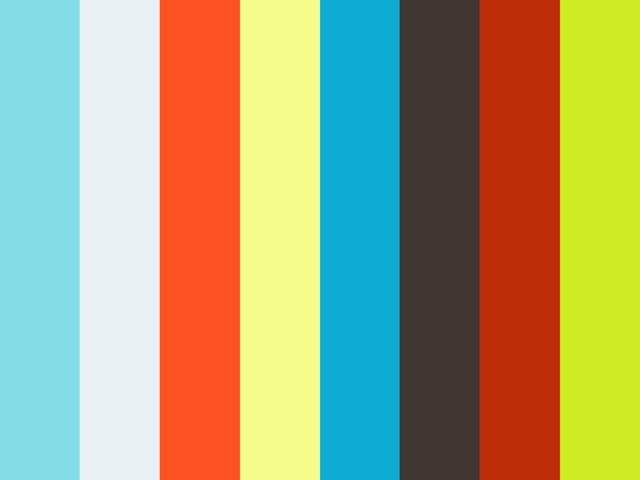](https://vimeo.com/3235882#t=)

Figure: <i>The latent doodle space idea of Baxter and Anjyo (2006)
manages to build a smooth mapping across very sparse data.</i>

**Generalization with much less Data than Dimensions**

-   Powerful uncertainly handling of GPs leads to surprising properties.

-   Non-linear models can be used where there are fewer data points than
    dimensions *without overfitting*.

<span style="text-align:right">(Baxter and Anjyo, 2006)</span>

Example: Continuous Character Control
-------------------------------------

-   Graph diffusion prior for enforcing connectivity between motions.
    $$\log p(\mathbf{X}) = w_c \sum_{i,j} \log K_{ij}^d$$ with the graph
    diffusion kernel $\mathbf{K}^d$ obtain from
    $$K_{ij}^d = \exp(\beta \mathbf{H})
    \qquad \text{with} \qquad \mathbf{H} = -\mathbf{T}^{-1/2} \mathbf{L} \mathbf{T}^{-1/2}$$
    the graph Laplacian, and $\mathbf{T}$ is a diagonal matrix with
    $T_{ii} = \sum_j w(\mathbf{ x}_i, \mathbf{ x}_j)$,
    $$L_{ij} = \begin{cases} \sum_k w(\mathbf{ x}_i,\mathbf{ x}_k) & \text{if $i=j$}
    \\
    -w(\mathbf{ x}_i,\mathbf{ x}_j) &\text{otherwise.}
    \end{cases}$$ and
    $w(\mathbf{ x}_i,\mathbf{ x}_j) = || \mathbf{ x}_i - \mathbf{ x}_j||^{-p}$
    measures similarity.

(Levine et al., 2012){style=“text-align:right”}

Character Control: Results
--------------------------

In [ ]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('hr3pdDl5IAg')

Figure: <i>Character control in the latent space described the the
GP-LVM Levine et al. (2012).</i>

Data for Blastocyst Development in Mice: Single Cell TaqMan Arrays
------------------------------------------------------------------

Now we analyze some single cell data from Guo et al. (2010). Tey
performed qPCR TaqMan array on single cells from the developing
blastocyst in mouse. The data is taken from the early stages of
development when the Blastocyst is forming. At the 32 cell stage the
data is already separated into the trophectoderm (TE) which goes onto
form the placenta and the inner cellular mass (ICM). The ICM further
differentiates into the epiblast (EPI)—which gives rise to the endoderm,
mesoderm and ectoderm—and the primitive endoderm (PE) which develops
into the amniotic sack. Guo et al. (2010) selected 48 genes for
expression measurement. They labelled the resulting cells and their
labels are included as an aide to visualization.

They first visualized their data using principal component analysis. In
the first two principal components this fails to separate the domains.
This is perhaps because the principal components are dominated by the
variation in the 64 cell systems. This in turn may be because there are
more cells from the data set in that regime, and may be because the
natural variation is greater. We first recreate their visualization
using principal component analysis.

In this notebook we will perform PCA on the original data, showing that
the different regimes do not separate.

Next we load in the data. We’ve provided a convenience function for
loading in the data with `pods`. It is loaded in as a `pandas`
DataFrame. This allows us to summarize it with the `describe` attribute.

In [ ]:
import pods

In [ ]:
data = pods.datasets.singlecell()
Y = data['Y']
Y.describe

Principal Component Analysis
----------------------------

Now we follow Guo et al. (2010) in performing PCA on the data. Rather
than calling a ‘PCA routine’, here we break the algorithm down into its
steps: compute the data covariance, compute the eigenvalues and
eigenvectors and sort according to magnitude of eigenvalue. Because we
want to visualize the data, we’ve chose to compute the eigenvectors of
the *inner product matrix* rather than the covariance matrix. This
allows us to plot the eigenvalues directly. However, this is less
efficient (in this case because the number of genes is smaller than the
number of data) than computing the eigendecomposition of the covariance
matrix.

In [ ]:
import numpy as np

In [ ]:
# obtain a centred version of data.
centredY = Y - Y.mean()
# compute inner product matrix
C = np.dot(centredY,centredY.T)
# perform eigendecomposition
V, U = np.linalg.eig(C)
# sort eigenvalues and vectors according to size
ind = V.argsort()
ev = V[ind[::-1]]
U = U[:, ind[::-1]]

To visualize the result, we now construct a simple helper function. This
will ensure that the plots have the same legends as the GP-LVM plots we
use below.

In [ ]:
import GPy
import matplotlib.pyplot as plt

In [ ]:
def plot_labels(ax, x, y, labels, symbols):
    """A small helper function for plotting with labels"""
    # make sure labels are in order of input:
    ulabels = []
    for lab in labels:
        if not lab in ulabels:
            ulabels.append(lab)
    for i, label in enumerate(ulabels):
        symbol = symbols[i % len(symbols)]
        ind = labels == label
        ax.plot(x[ind], y[ind], symbol)
    ax.legend(ulabels)

PCA Result
----------

Now, using the helper function we can plot the results with appropriate
labels.

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
plot_labels(ax, U[:, 0], U[:, 1], data['labels'], '<>^vsd')

mlai.write_figure('singlecell-data-pca.svg', directory='./datasets')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/datasets/singlecell-data-pca.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>First two principal compoents of the Guo et al. (2010)
blastocyst development data.</i>

GP-LVM on the Data
------------------

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip0">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Max Zwiessele

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="../slides/diagrams/people/max-zwiessele.jpg" clip-path="url(#clip0)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip1">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Oliver Stegle

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="../slides/diagrams/people/oliver-stegle.jpg" clip-path="url(#clip1)"/>

</svg>

Work done as a collaboration between Max Zwiessele, Oliver Stegle and
Neil D. Lawrence.

Then, we follow Buettner and Theis (2012) in applying the GP-LVM to the
data. There is a slight pathology in the result, one which they fixed by
using priors that were dependent on the developmental stage. We then
show how the Bayesian GP-LVM doesn’t exhibit those pathologies and gives
a nice results that seems to show the lineage of the cells.

They used modified prior to ensure that small differences between cells
at the same differential stage were preserved. Here we apply a standard
GP-LVM (no modified prior) to the data.

In [ ]:
import GPy

In [ ]:
kernel = GPy.kern.RBF(2)+GPy.kern.Bias(2)
model = GPy.models.GPLVM(Y.values, 2, kernel=kernel)
model.optimize(messages=True)

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
model.plot_latent(ax=ax, labels=data['labels'], marker='<>^vsd')

mlai.write_figure('singlecell-gplvm.svg', directory='./gplvm')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gplvm/singlecell-gplvm.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>Visualisation of the Guo et al. (2010) blastocyst development
data with the GP-LVM.</i>

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
model.kern.plot_ARD(ax=ax)

mlai.write_figure('singlecell-gplvm-ard.svg', directory='./gplvm')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/gplvm/singlecell-gplvm-ard.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The ARD parameters of the GP-LVM for the Guo et al. (2010)
blastocyst development data.</i>

Blastocyst Data: Isomap
-----------------------

Isomap first builds a neighbourhood graph, and then uses distances along
this graph to approximate the geodesic distance between points. These
distances are then visualized by performing classical multidimensional
scaling (which involves computing the eigendecomposition of the centred
distance matrix). As the neighborhood size is increased to match the
data, principal component analysis is recovered (or strictly speaking,
principal coordinate analysis). The fewer the neighbors, the more
‘non-linear’ the isomap embeddings are.

In [ ]:
import sklearn.manifold

In [ ]:
n_neighbors = 10
model = sklearn.manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
X = model.fit_transform(Y)

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
plot_labels(ax, X[:, 0], X[:, 1], data['labels'], '<>^vsd')


mlai.write_figure('singlecell-isomap.svg', directory='./dimred')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/singlecell-isomap.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>Visualisation of the Guo et al. (2010) blastocyst development
data with Isomap.</i>

Blastocyst Data: Locally Linear Embedding
-----------------------------------------

Next we try locally linear embedding. In locally linear embedding a
neighborhood is also computed. Each point is then reconstructed by it’s
neighbors using a linear weighting. This implies a locally linear patch
is being fitted to the data in that region. These patches are
assimilated into a large $n\times n$ matrix and a lower dimensional data
set which reflects the same relationships is then sought. Quite a large
number of neighbours needs to be selected for the data to not collapse
in on itself. When a large number of neighbours is selected the
embedding is more linear and begins to look like PCA. However, the
algorithm does *not* converge to PCA in the limit as the number of
neighbors approaches $n$.

In [ ]:
import sklearn.manifold

In [ ]:
n_neighbors = 50
model = sklearn.manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2)
X = model.fit_transform(Y)

In [ ]:
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai

In [ ]:
fig, ax = plt.subplots(figsize=plot.big_figsize)
model.plot_latent(ax=ax, X[:, 0], X[:, 1], data['labels'], '<>^vsd')

mlai.write_figure('singlecell-lle.svg', directory='./dimred')

<img src="http://inverseprobability.com/talks/slides/../slides/diagrams/dimred/singlecell-lle.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>Visualisation of the Guo et al. (2010) blastocyst development
data with a locally linear embedding.</i>

Thanks!
-------

For more information on these subjects and more you might want to check
the following resources.

-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

References
----------

Baxter, W.V., Anjyo, K.-I., 2006. Latent doodle space, in: EUROGRAPHICS.
Vienna, Austria, pp. 477–485.
<https://doi.org/10.1111/j.1467-8659.2006.00967.x>

Bishop, C.M., 2006. Pattern recognition and machine learning. springer.

Buettner, F., Theis, F.J., 2012. A novel approach for resolving
differences in single-cell gene expression patterns from zygote to
blastocyst. Bioinformatics 28, i626–i632.
<https://doi.org/10.1093/bioinformatics/bts385>

CMU Motion Capture Labb, 2003. The CMU mocap database.

Damianou, A., Lawrence, N.D., 2013. Deep Gaussian processes, in:. pp.
207–215.

de Campos, T.E., Babu, B.R., Varma, M., 2009. Character recognition in
natural images, in: Proceedings of the Fourth International Conference
on Computer Vision Theory and Applications - Volume 2: VISAPP,
(Visigrapp 2009). INSTICC; SciTePress, pp. 273–280.
<https://doi.org/10.5220/0001770102730280>

Grochow, K., Martin, S.L., Hertzmann, A., Popovic, Z., 2004. Style-based
inverse kinematics, in: ACM Transactions on Graphics (Siggraph 2004).
pp. 522–531. <https://doi.org/10.1145/1186562.1015755>

Guo, G., Huss, M., Tong, G.Q., Wang, C., Sun, L.L., Clarke, N.D.,
Robsonemail, P., 2010. Resolution of cell fate decisions revealed by
single-cell gene expression analysis from zygote to blastocyst.
Developmental Cell 18, 675–685.
<https://doi.org/10.1016/j.devcel.2010.02.012>

Hastie, T., Stuetzle, W., 1989. Principal curves. Journal of the
American Statistical Association 84, 502–516.

Hotelling, H., 1933. Analysis of a complex of statistical variables into
principal components. Journal of Educational Psychology 24, 417–441.

Lawrence, N.D., n.d. Gaussian process models for visualisation of high
dimensional data, in:. pp. 329–336.

Lawrence, N.D., 2005. Probabilistic non-linear principal component
analysis with Gaussian process latent variable models. Journal of
Machine Learning Research 6, 1783–1816.

Lawrence, N.D., Moore, A.J., 2007. Hierarchical Gaussian process latent
variable models, in:. pp. 481–488.

Le Cun, Y., Boser, B.E., Denker, J.S., Henderson, D., Howard, R.E.,
Hubbard, W., Jackel, L.D., 1989. Backpropagation applied to handwritten
zip code recognition. Neural Computation 1, 541–551.
<https://doi.org/10.1162/neco.1989.1.4.541>

Levine, S., Wang, J.M., Haraux, A., Popović, Z., Koltun, V., 2012.
Continuous character control with low-dimensional embeddings. ACM
Transactions on Graphics (SIGGRAPH 2012) 31.

Mardia, K.V., Kent, J.T., Bibby, J.M., 1979. Multivariate analysis.
Academic Press, London.

Pearson, K., 1901. On lines and planes of closest fit to systems of
points in space. The London, Edinburgh and Dublin Philosophical Magazine
and Journal of Science, Sixth Series 2, 559–572.

Roweis, S.T., n.d. EM algorithms for PCA and SPCA, in:. pp. 626–632.

Schölkopf, B., Smola, A., Müller, K.-R., 1998. Nonlinear component
analysis as a kernel eigenvalue problem. Neural Computation 10,
1299–1319. <https://doi.org/10.1162/089976698300017467>

Tipping, M.E., Bishop, C.M., 1999a. Probabilistic principal component
analysis. Journal of the Royal Statistical Society, B 6, 611–622.
<https://doi.org/doi:10.1111/1467-9868.00196>

Tipping, M.E., Bishop, C.M., 1999b. Mixtures of probabilistic principal
component analysers. Neural Computation 11, 443–482.

Urtasun, R., Fleet, D.J., Fua, P., 2006. 3D people tracking with
Gaussian process dynamical models, in: Proceedings of the IEEE Computer
Society Conference on Computer Vision and Pattern Recognition. IEEE
Computer Society Press, New York, U.S.A., pp. 238–245.
<https://doi.org/10.1109/CVPR.2006.15>